In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

np.random.seed(0)

In [ ]:
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    """
    Plot feature importance
    """
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(15, 10))
    sns.barplot(data=importances, x='importance', y='feature', color='skyblue')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return importances

#### Random forest (todos los errores)

In [26]:
datos = pd.read_csv('Data_final.csv')
X = datos.iloc[:,:-1]
y = datos.iloc[:,-1]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
rf_model = RandomForestClassifier(random_state=42, max_depth = None, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)


Feature Importance Analysis:


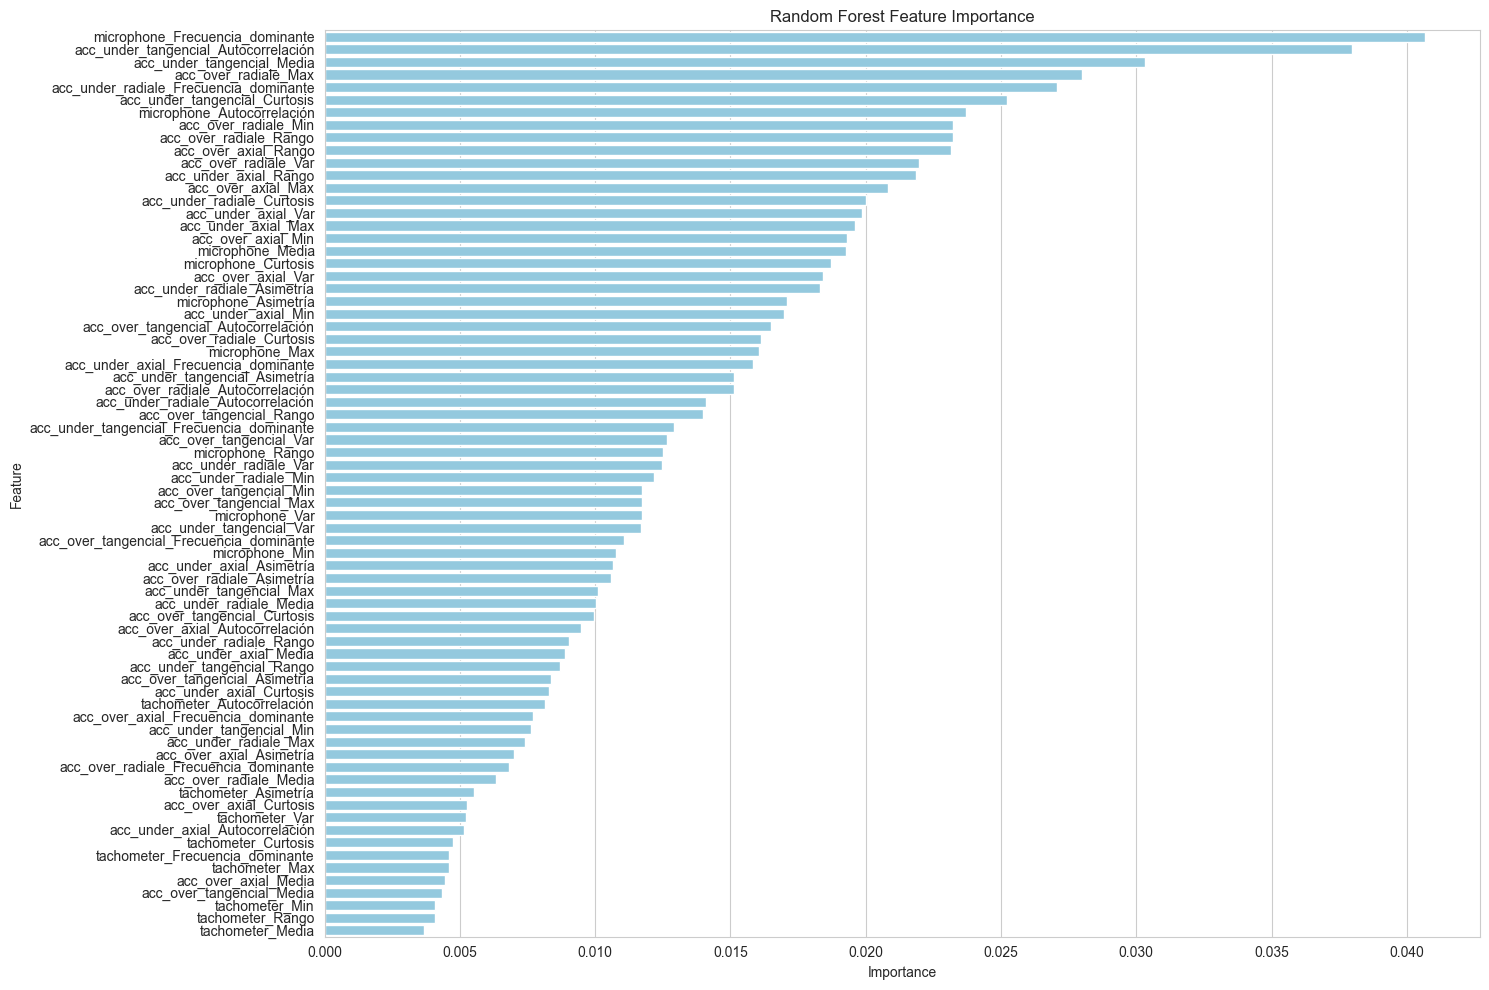


Feature Importance Ranking:
                                   feature  importance
71         microphone_Frecuencia_dominante    0.040672
34    acc_under_tangencial_Autocorrelación    0.037973
27              acc_under_tangencial_Media    0.030311
47                    acc_over_radiale_Max    0.027991
26  acc_under_radiale_Frecuencia_dominante    0.027074
..                                     ...         ...
36                    acc_over_axial_Media    0.004456
54               acc_over_tangencial_Media    0.004334
3                           tachometer_Min    0.004098
4                         tachometer_Rango    0.004089
0                         tachometer_Media    0.003684

[72 rows x 2 columns]


In [29]:
print("\nFeature Importance Analysis:")
importance_df = plot_feature_importance(rf_model, X.columns,
                                     "Random Forest Feature Importance")
print("\nFeature Importance Ranking:")
print(importance_df)

In [30]:
# Seleccionar las filas cuyo valor en 'importance' sea >= 0.01
selected_features = importance_df[importance_df['importance'] >= 0.01]
print(selected_features)

                                      feature  importance
71            microphone_Frecuencia_dominante    0.040672
34       acc_under_tangencial_Autocorrelación    0.037973
27                 acc_under_tangencial_Media    0.030311
47                       acc_over_radiale_Max    0.027991
26     acc_under_radiale_Frecuencia_dominante    0.027074
33              acc_under_tangencial_Curtosis    0.025208
70                 microphone_Autocorrelación    0.023717
48                       acc_over_radiale_Min    0.023239
49                     acc_over_radiale_Rango    0.023233
40                       acc_over_axial_Rango    0.023137
46                       acc_over_radiale_Var    0.021970
13                      acc_under_axial_Rango    0.021851
38                         acc_over_axial_Max    0.020826
24                 acc_under_radiale_Curtosis    0.020020
10                        acc_under_axial_Var    0.019850
11                        acc_under_axial_Max    0.019603
39            

In [31]:
# Calcular la suma de importancias del subconjunto seleccionado
suma_sub_importancia = selected_features['importance'].sum()

# Calcular la proporción en porcentaje
proporcion_importancia = suma_sub_importancia * 100

print(f'El subconjunto seleccionado representa el {proporcion_importancia:.2f}% del total de importancia.')

El subconjunto seleccionado representa el 83.05% del total de importancia.


In [32]:
X_reduced = X[selected_features['feature']]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
rf_model = RandomForestClassifier(random_state=42, max_depth = None, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       0.91      1.00      0.95        10
horizontal-misalignment_1.0mm       1.00      0.90      0.95        10
horizontal-misalignment_1.5mm       1.00      1.00      1.00        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      1.00      1.00         9
                imbalance_15g       0.88      0.70      0.78        10
                imbalance_20g       0.73      0.80      0.76        10
                imbalance_25g       0.89      0.89      0.89         9
                imbalance_30g       0.89      0.89      0.89         9
                imbalance_35g       0.89      0.89      0.89         9
                 imbalance_6g       1.00      1.00      1.00        10
                       normal       1.00      1.00      1.00        10
       overhang_ball_fault_0g       1.00      1.00      1.00        10
     

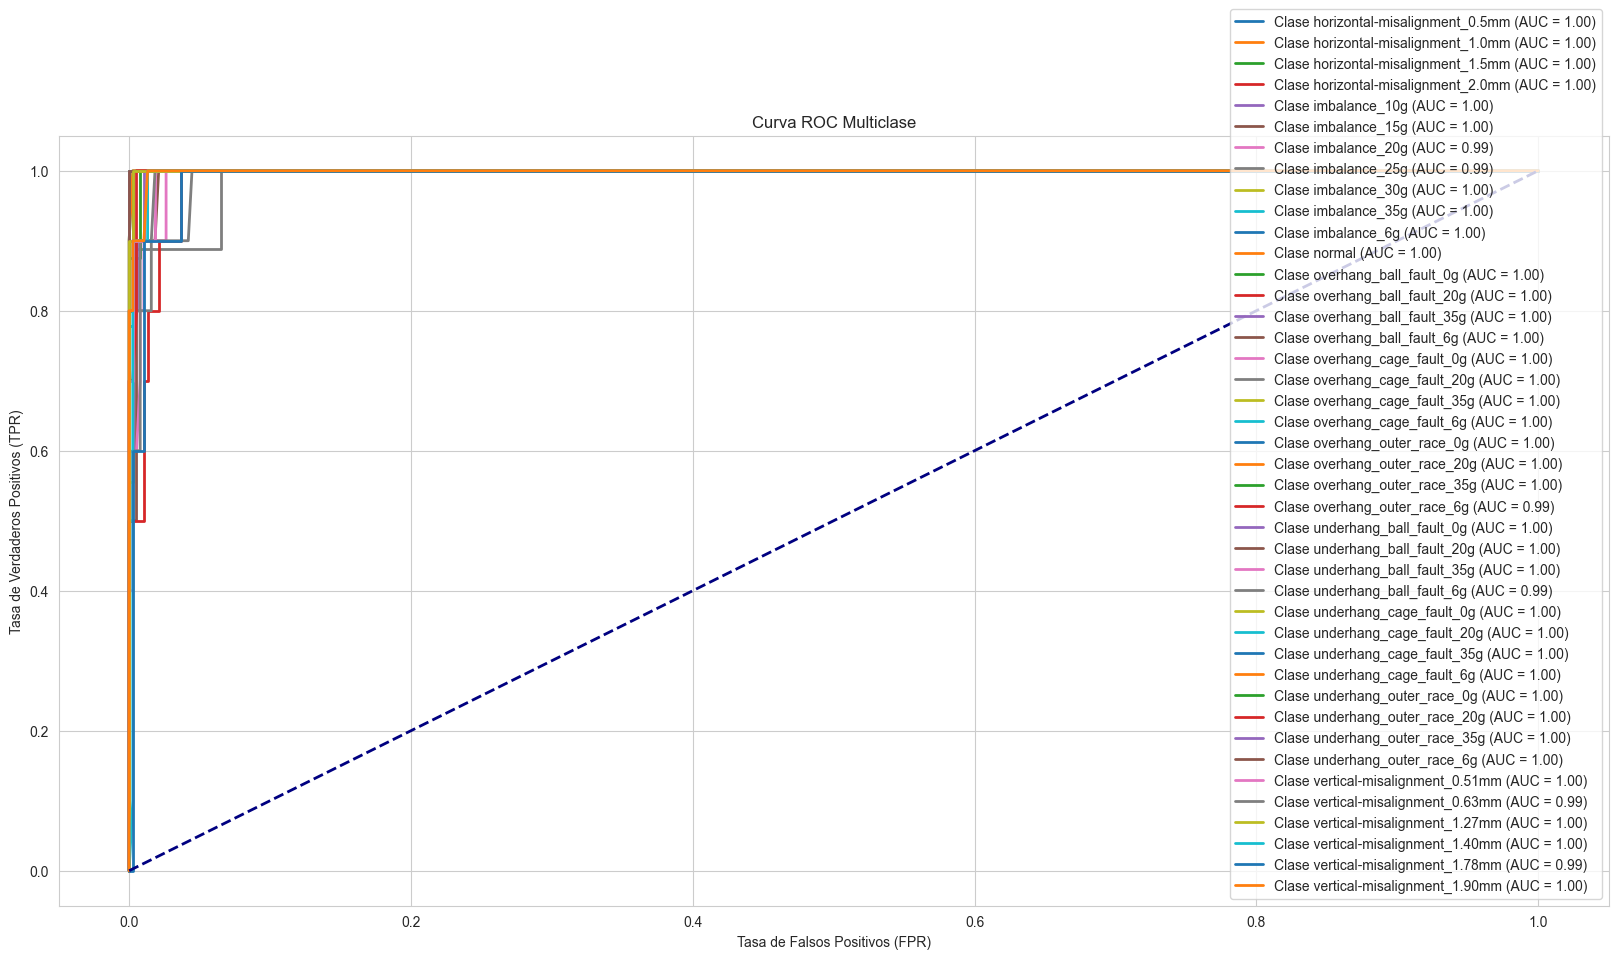

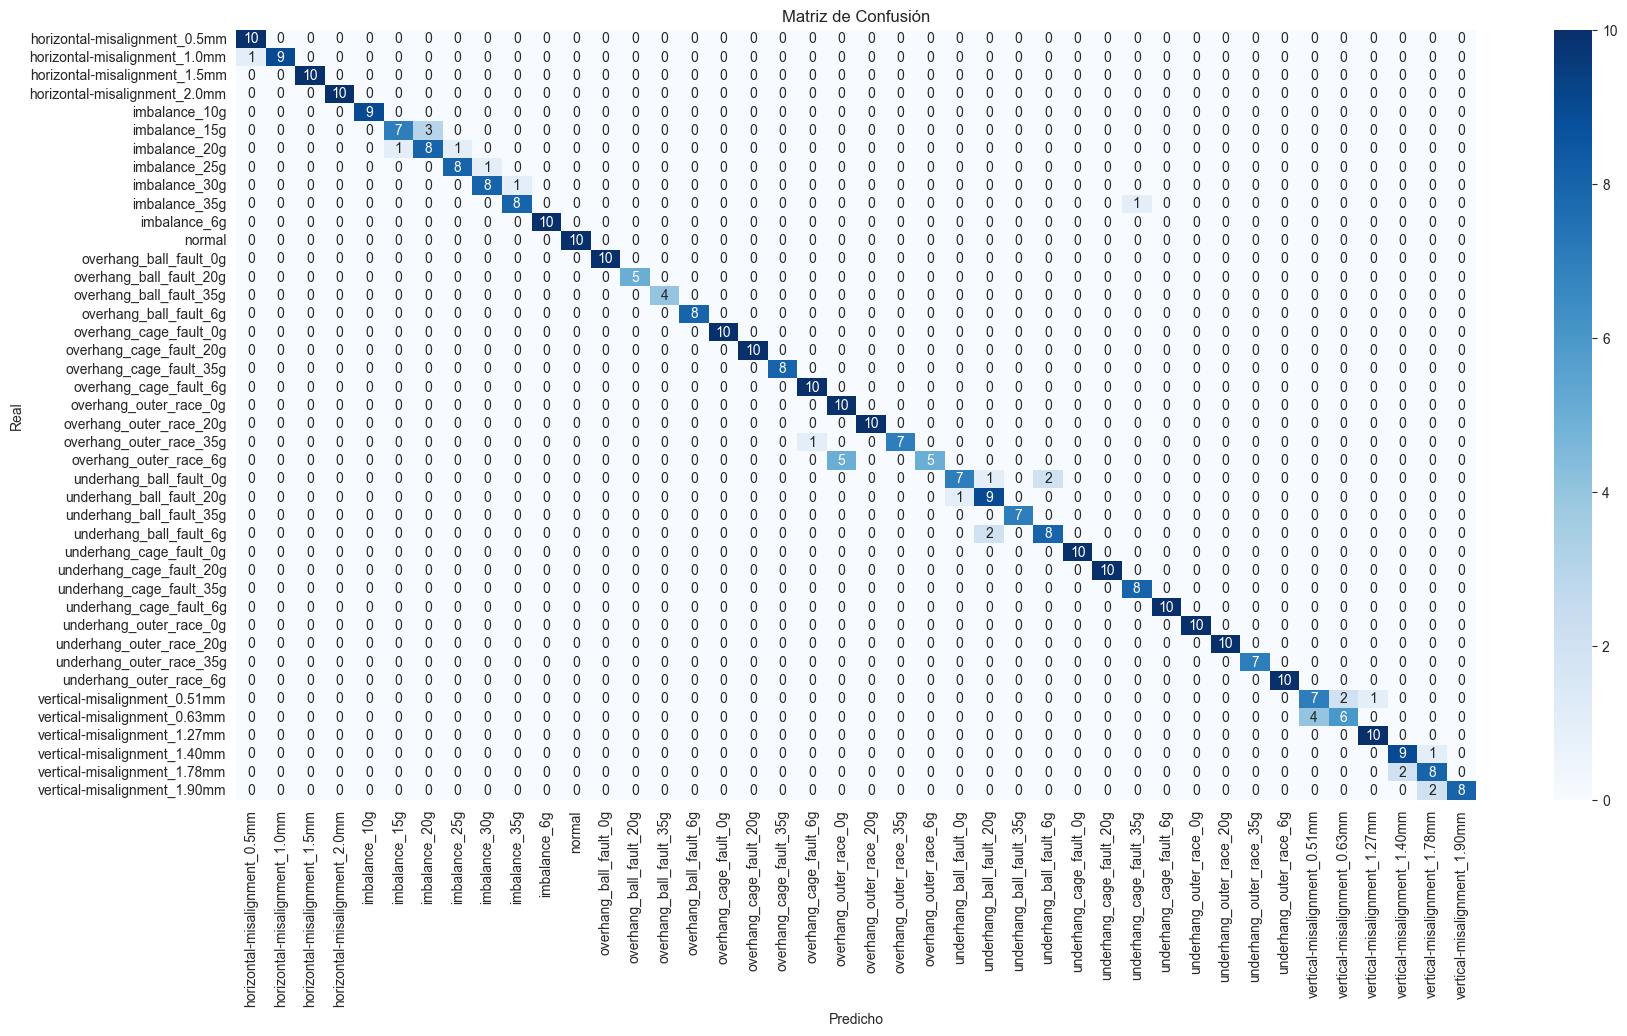

In [34]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

#### Quitar sensores (todos los errores)
Vamos a hacer las pruebas con RF que funciona mejor. Quitamos sensores y ver como influye al clasificar errores concretos.

##### Quitamos 'tachometer'

In [35]:
sensores = ['tachometer', 'acc_under_axial', 'acc_under_radiale', 'acc_under_tangencial', 'acc_over_axial', 'acc_over_radiale', 'acc_over_tangencial', 'microphone']

In [5]:
def generar_nombres_columnas(column):
    return [
        f'{column}_Media', 
        f'{column}_Var', 
        f'{column}_Max', 
        f'{column}_Min', 
        f'{column}_Rango',
        f'{column}_Asimetría', 
        f'{column}_Curtosis', 
        f'{column}_Autocorrelación', 
        f'{column}_Frecuencia_dominante'
    ]

In [37]:
datos = pd.read_csv('Data_final.csv')
X = datos.iloc[:,:-1]
y = datos.iloc[:,-1]

In [38]:
columnas_a_quitar = generar_nombres_columnas('tachometer')
print(columnas_a_quitar)

['tachometer_Media', 'tachometer_Var', 'tachometer_Max', 'tachometer_Min', 'tachometer_Rango', 'tachometer_Asimetría', 'tachometer_Curtosis', 'tachometer_Autocorrelación', 'tachometer_Frecuencia_dominante']


In [50]:
X_reducida = X.drop(columns=columnas_a_quitar)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida, y, test_size=0.2, random_state=42, stratify=y)

In [53]:
rf_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       0.91      1.00      0.95        10
horizontal-misalignment_1.0mm       1.00      0.90      0.95        10
horizontal-misalignment_1.5mm       1.00      1.00      1.00        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      1.00      1.00         9
                imbalance_15g       0.80      0.80      0.80        10
                imbalance_20g       0.78      0.70      0.74        10
                imbalance_25g       0.80      0.89      0.84         9
                imbalance_30g       0.88      0.78      0.82         9
                imbalance_35g       0.89      0.89      0.89         9
                 imbalance_6g       1.00      1.00      1.00        10
                       normal       1.00      1.00      1.00        10
       overhang_ball_fault_0g       1.00      1.00      1.00        10
     

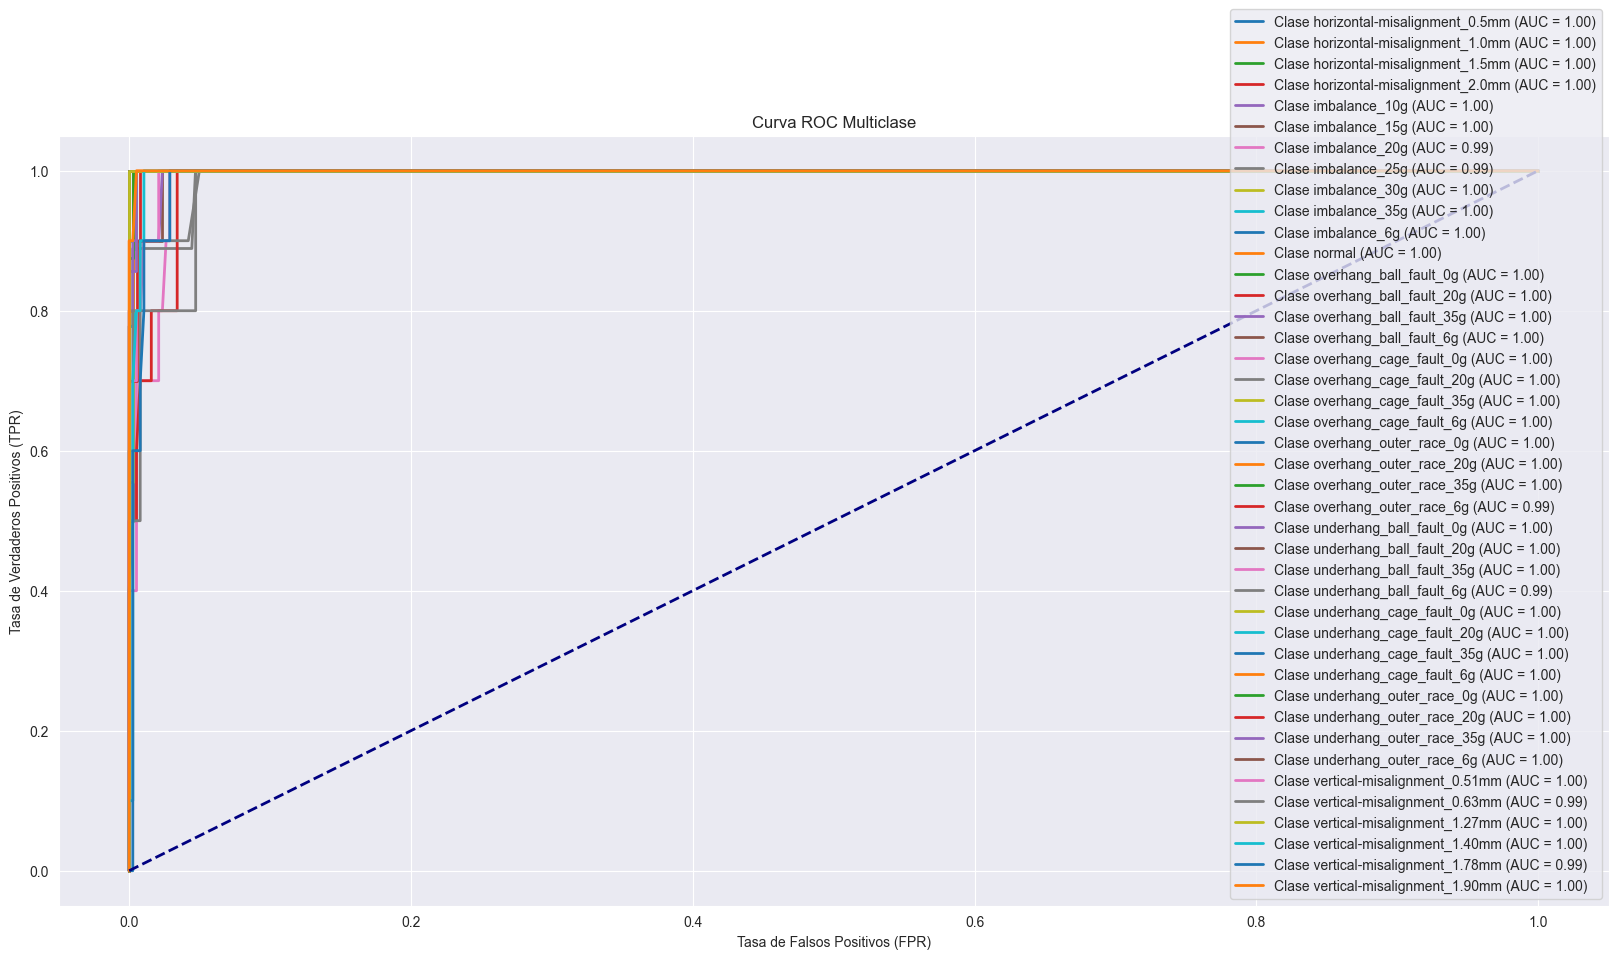

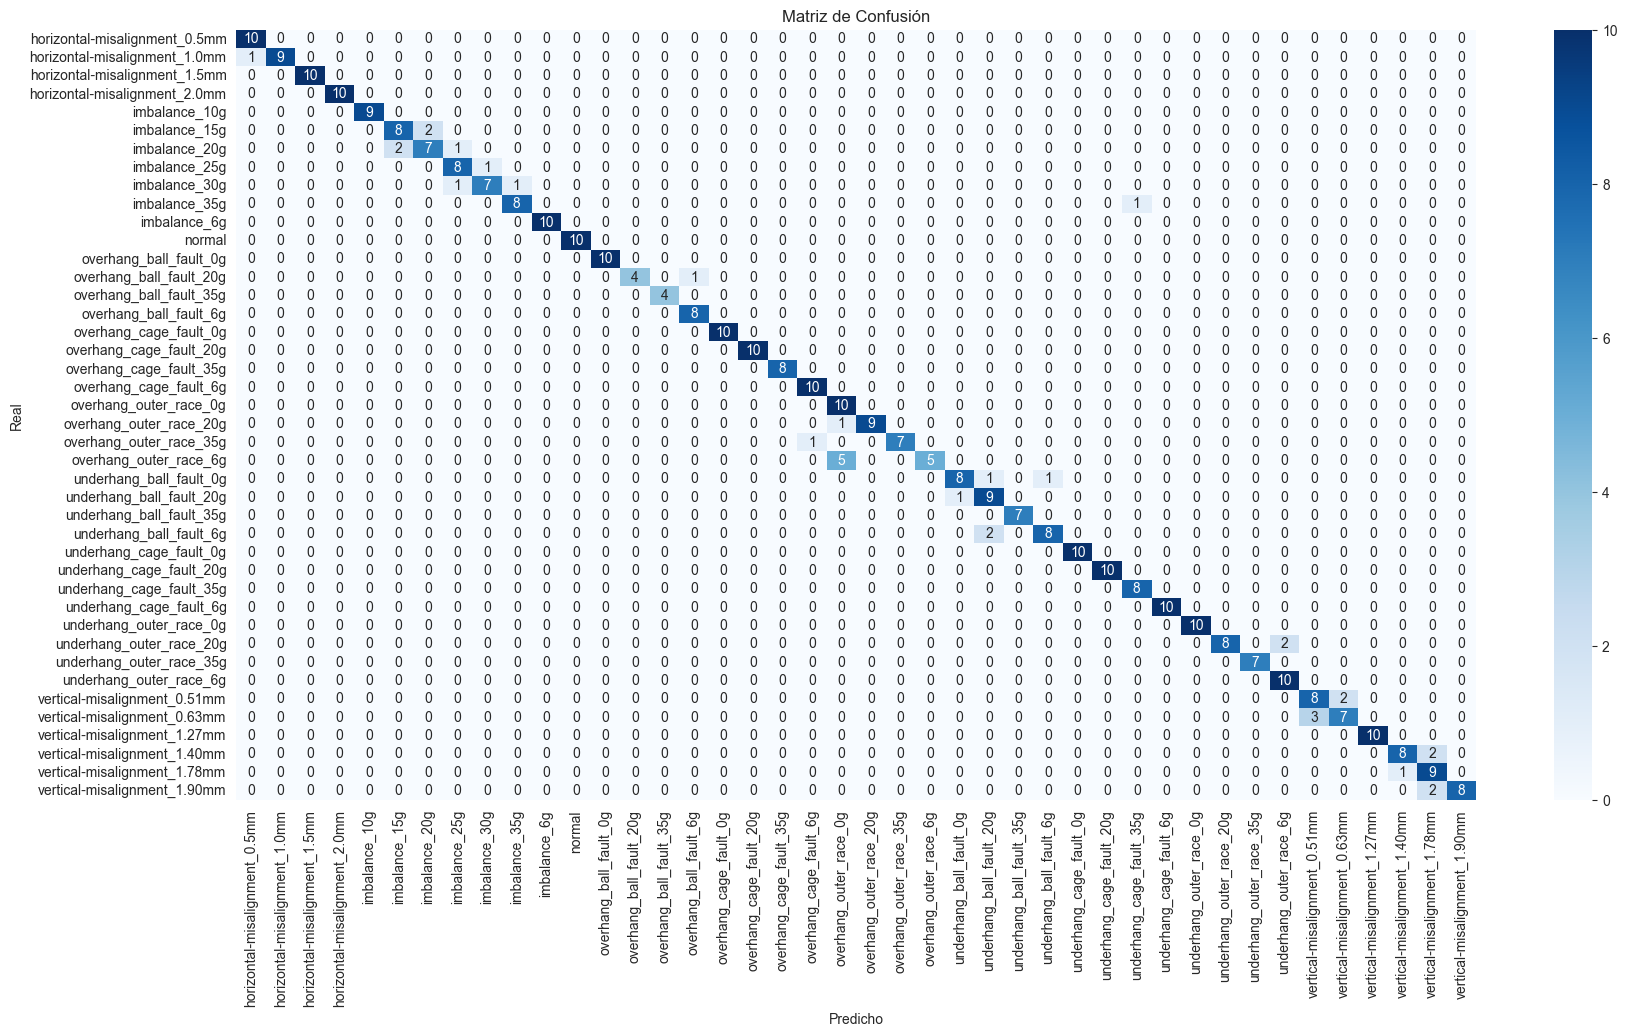

In [55]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

La accuracy total baja 0.01.


##### Quitamos 'acc_under_axial'

In [ ]:
datos = pd.read_csv('Data_final.csv')
X = datos.iloc[:,:-1]
y = datos.iloc[:,-1]

In [56]:
columnas_a_quitar = generar_nombres_columnas('acc_under_axial')
print(columnas_a_quitar)

['acc_under_axial_Media', 'acc_under_axial_Var', 'acc_under_axial_Max', 'acc_under_axial_Min', 'acc_under_axial_Rango', 'acc_under_axial_Asimetría', 'acc_under_axial_Curtosis', 'acc_under_axial_Autocorrelación', 'acc_under_axial_Frecuencia_dominante']


In [57]:
X_reducida = X.drop(columns=columnas_a_quitar)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida, y, test_size=0.2, random_state=42, stratify=y)

In [59]:
rf_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       0.91      1.00      0.95        10
horizontal-misalignment_1.0mm       1.00      0.90      0.95        10
horizontal-misalignment_1.5mm       1.00      1.00      1.00        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      1.00      1.00         9
                imbalance_15g       0.89      0.80      0.84        10
                imbalance_20g       0.80      0.80      0.80        10
                imbalance_25g       0.89      0.89      0.89         9
                imbalance_30g       0.89      0.89      0.89         9
                imbalance_35g       0.89      0.89      0.89         9
                 imbalance_6g       1.00      1.00      1.00        10
                       normal       1.00      1.00      1.00        10
       overhang_ball_fault_0g       0.91      1.00      0.95        10
     

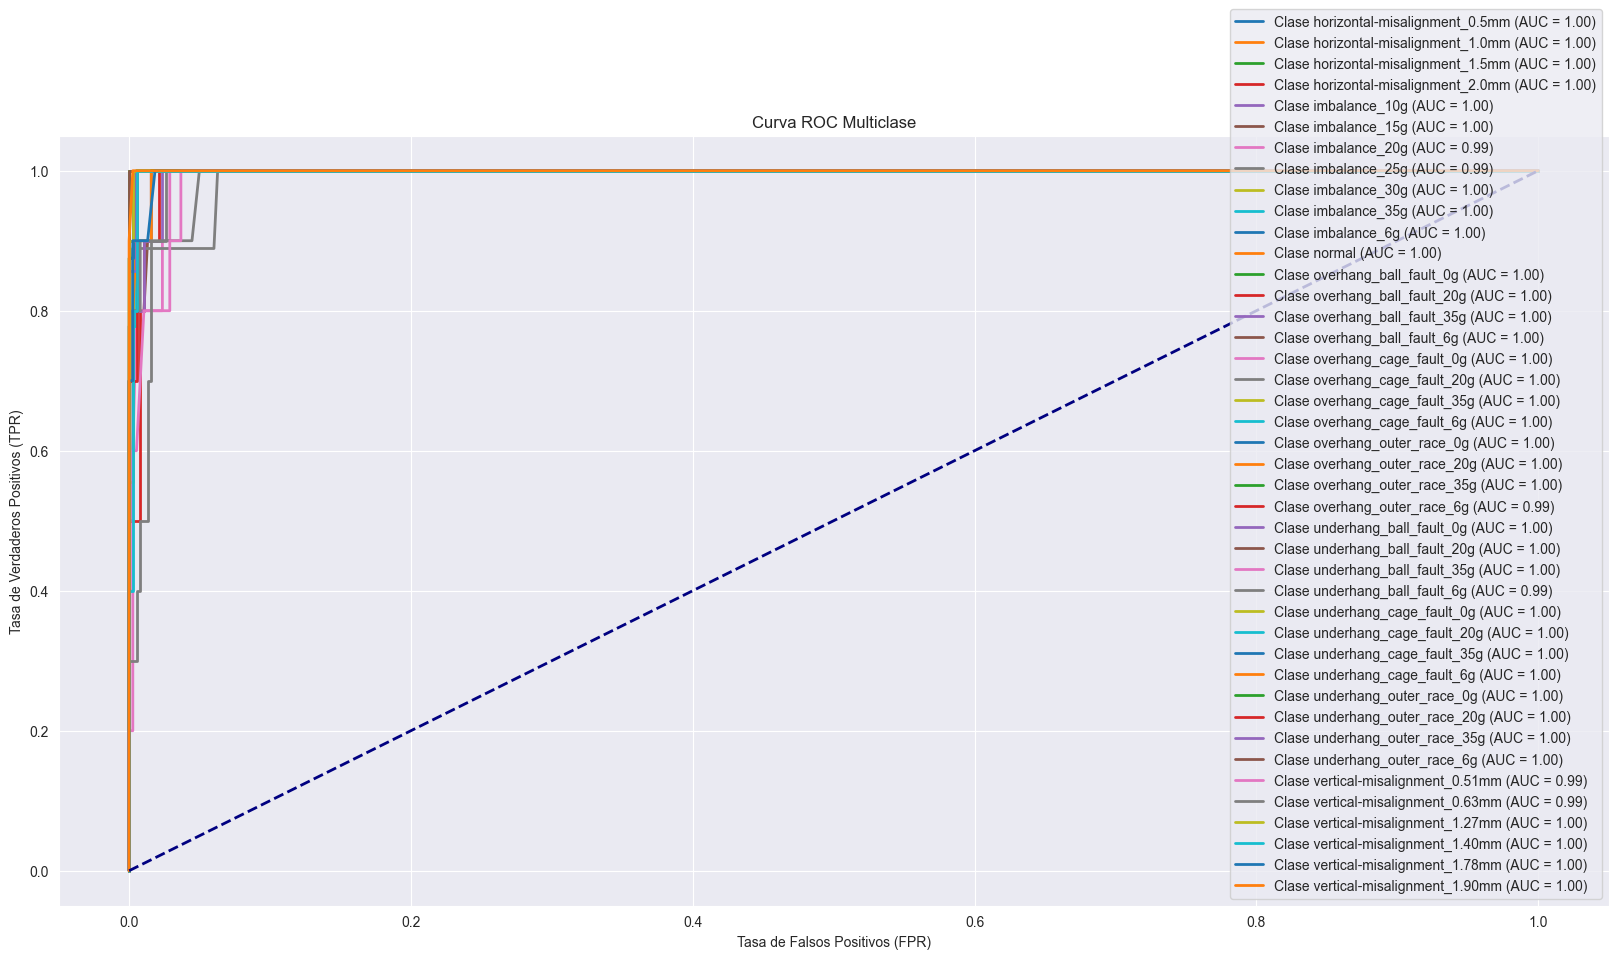

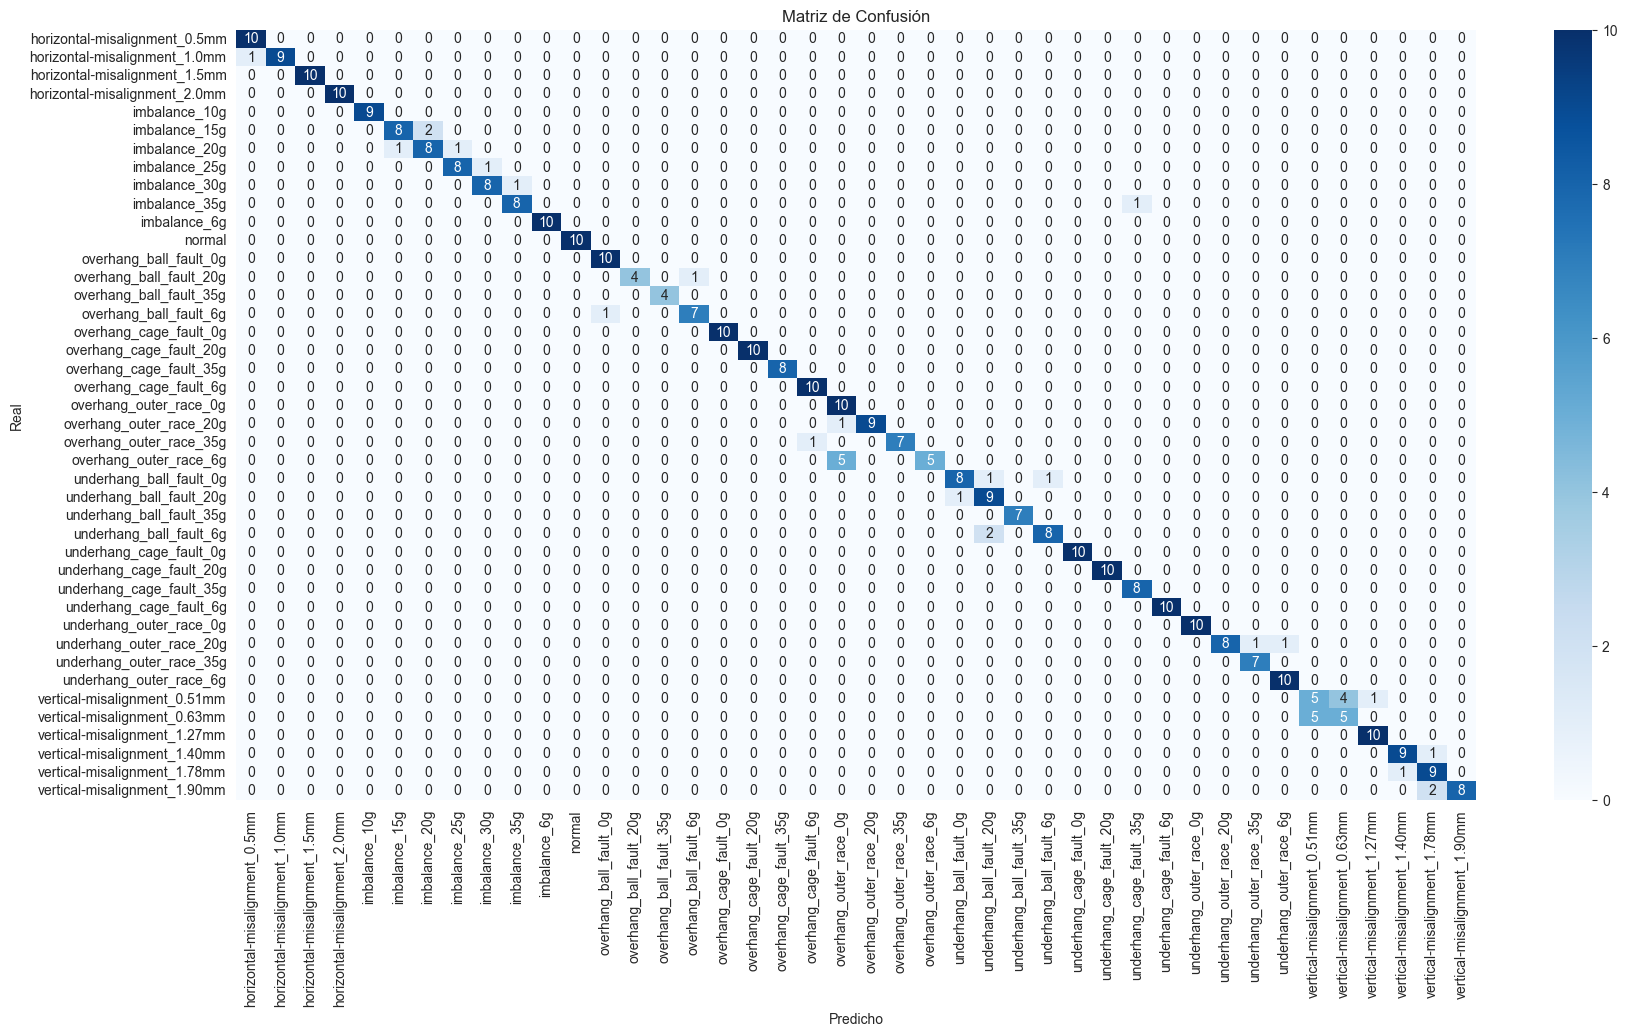

In [60]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

La accuracy total baja 0.02

##### Quitamos 'acc_under_radial'

In [2]:
datos = pd.read_csv('Data_final.csv')

In [3]:
X = datos.iloc[:, :-1]
y = datos.iloc[:, -1]

In [6]:
columnas_a_quitar = generar_nombres_columnas('acc_under_axial')
print(columnas_a_quitar)

['acc_under_axial_Media', 'acc_under_axial_Var', 'acc_under_axial_Max', 'acc_under_axial_Min', 'acc_under_axial_Rango', 'acc_under_axial_Asimetría', 'acc_under_axial_Curtosis', 'acc_under_axial_Autocorrelación', 'acc_under_axial_Frecuencia_dominante']


In [7]:
X_reducida = X.drop(columns=columnas_a_quitar)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
rf_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       0.91      1.00      0.95        10
horizontal-misalignment_1.0mm       1.00      0.90      0.95        10
horizontal-misalignment_1.5mm       1.00      1.00      1.00        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      1.00      1.00         9
                imbalance_15g       0.89      0.80      0.84        10
                imbalance_20g       0.80      0.80      0.80        10
                imbalance_25g       0.89      0.89      0.89         9
                imbalance_30g       0.89      0.89      0.89         9
                imbalance_35g       0.89      0.89      0.89         9
                 imbalance_6g       1.00      1.00      1.00        10
                       normal       1.00      1.00      1.00        10
       overhang_ball_fault_0g       0.91      1.00      0.95        10
     

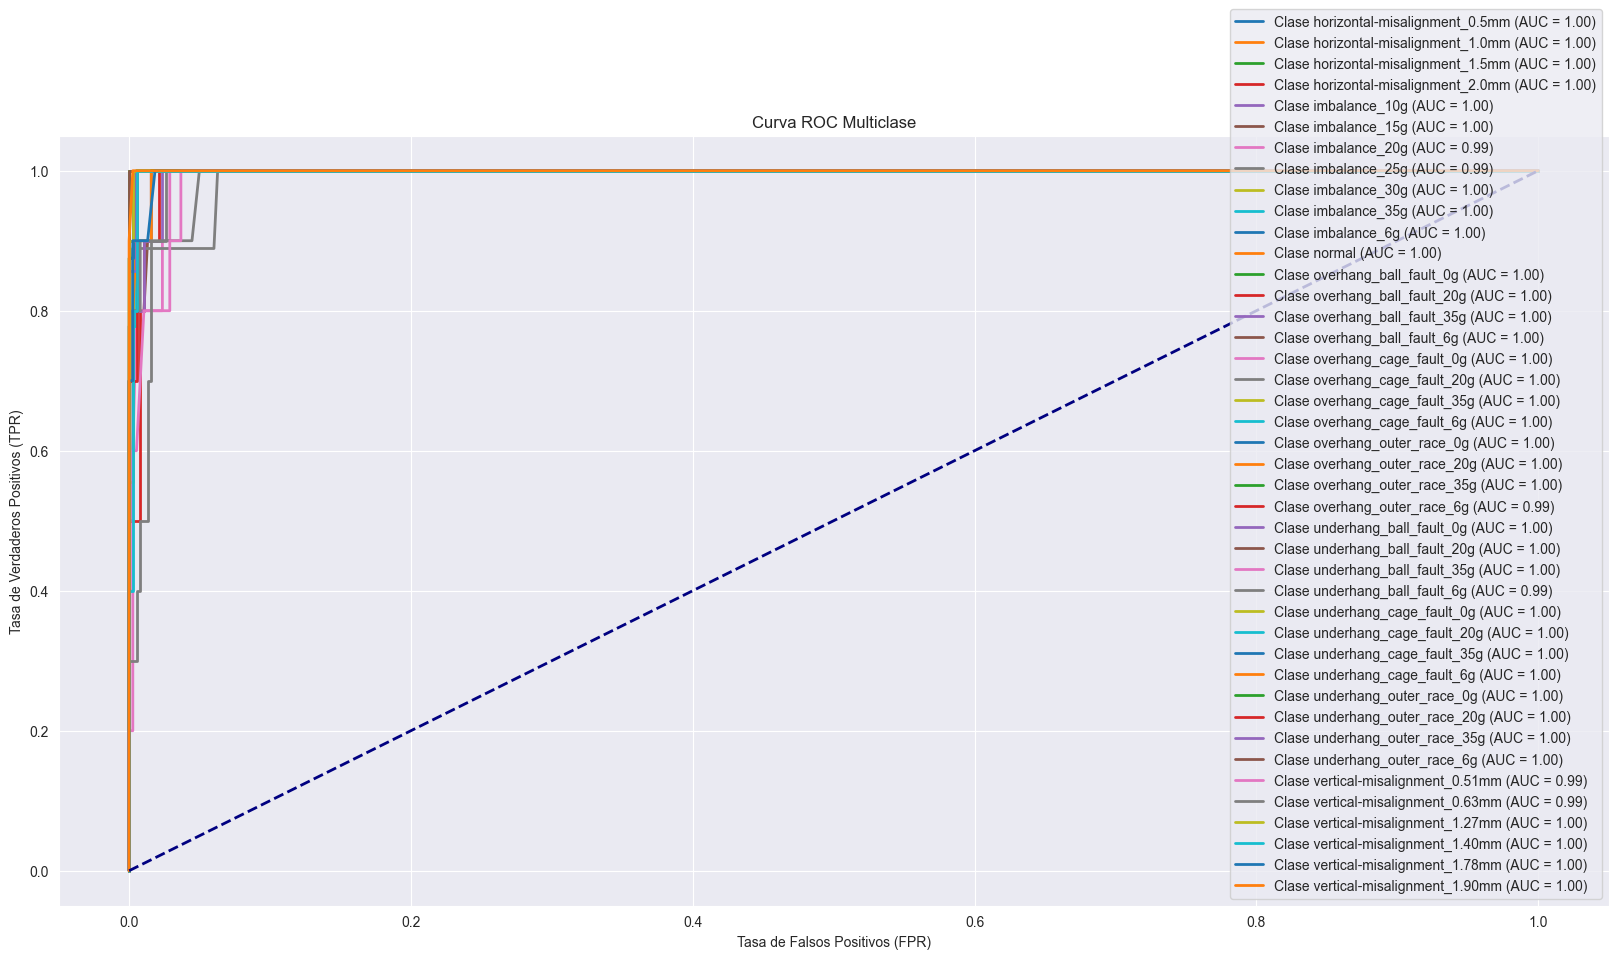

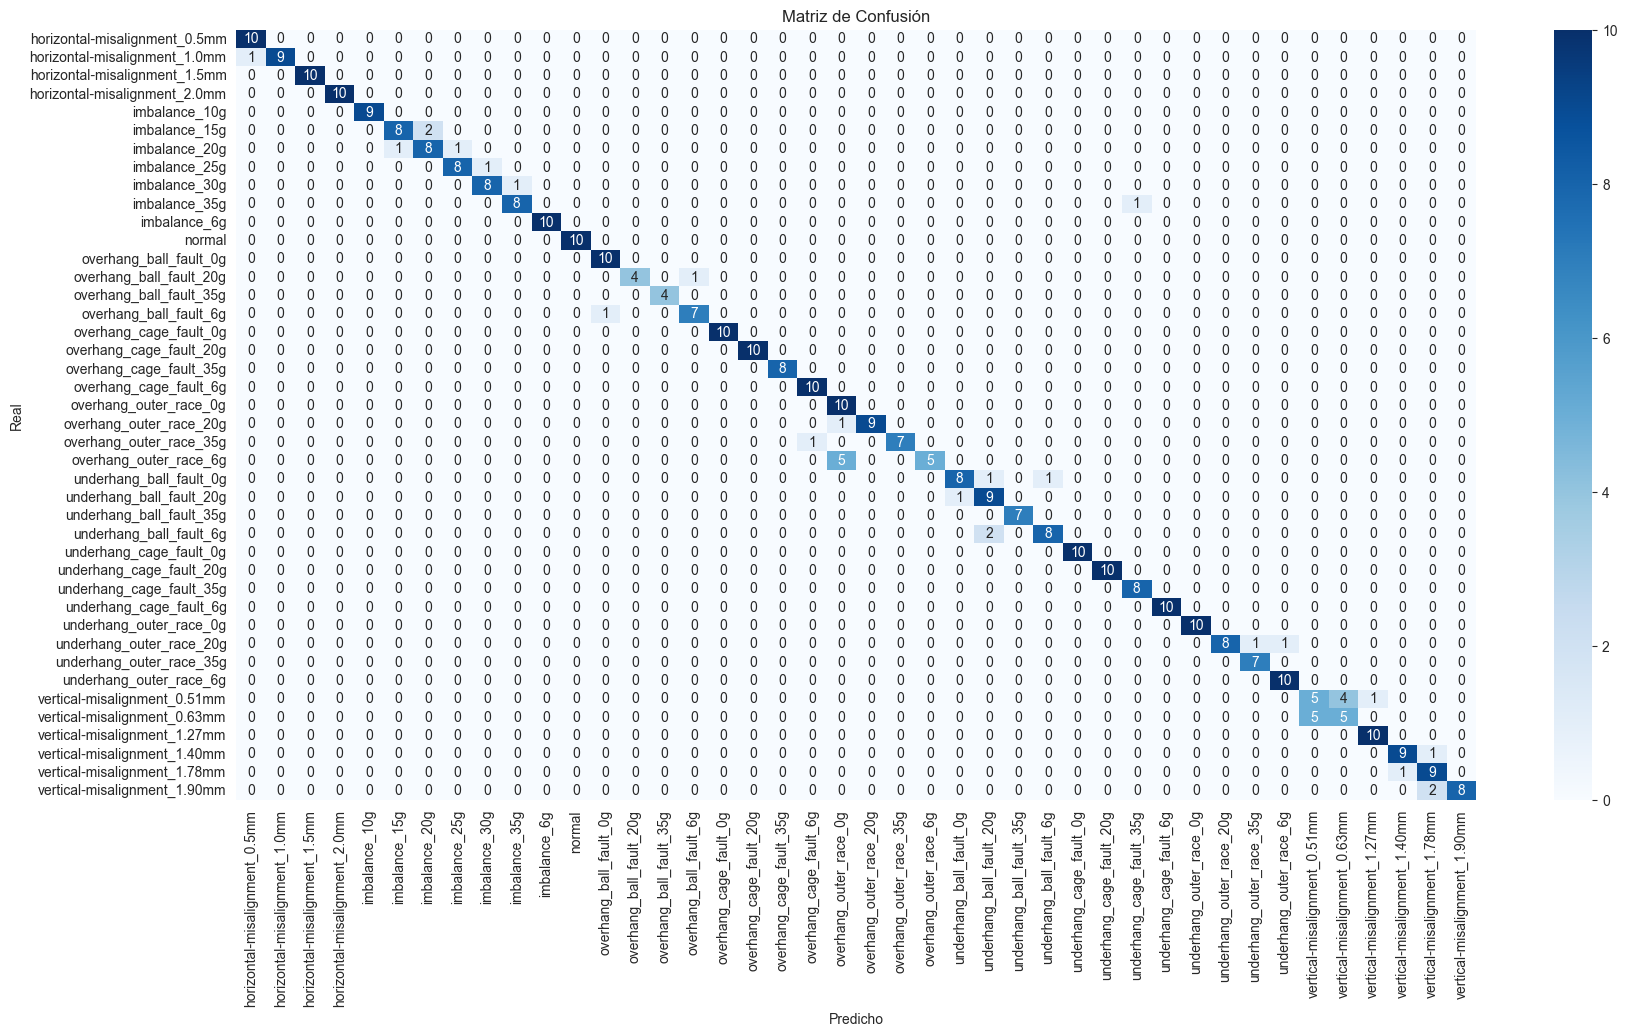

In [12]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

La accuracy baja 0.02

##### Quitamos 'acc_under_tangencial'

In [19]:
datos = pd.read_csv('Data_final.csv')
X = datos.iloc[:, :-1]
y = datos.iloc[:, -1]

In [20]:
columnas_a_quitar = generar_nombres_columnas('acc_under_tangencial')
print(columnas_a_quitar)

['acc_under_tangencial_Media', 'acc_under_tangencial_Var', 'acc_under_tangencial_Max', 'acc_under_tangencial_Min', 'acc_under_tangencial_Rango', 'acc_under_tangencial_Asimetría', 'acc_under_tangencial_Curtosis', 'acc_under_tangencial_Autocorrelación', 'acc_under_tangencial_Frecuencia_dominante']


In [21]:
X_reducida = X.drop(columns=columnas_a_quitar)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
rf_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       0.91      1.00      0.95        10
horizontal-misalignment_1.0mm       1.00      1.00      1.00        10
horizontal-misalignment_1.5mm       0.90      0.90      0.90        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      0.89      0.94         9
                imbalance_15g       0.75      0.60      0.67        10
                imbalance_20g       0.44      0.40      0.42        10
                imbalance_25g       0.55      0.67      0.60         9
                imbalance_30g       0.89      0.89      0.89         9
                imbalance_35g       0.88      0.78      0.82         9
                 imbalance_6g       0.91      1.00      0.95        10
                       normal       1.00      1.00      1.00        10
       overhang_ball_fault_0g       1.00      1.00      1.00        10
     

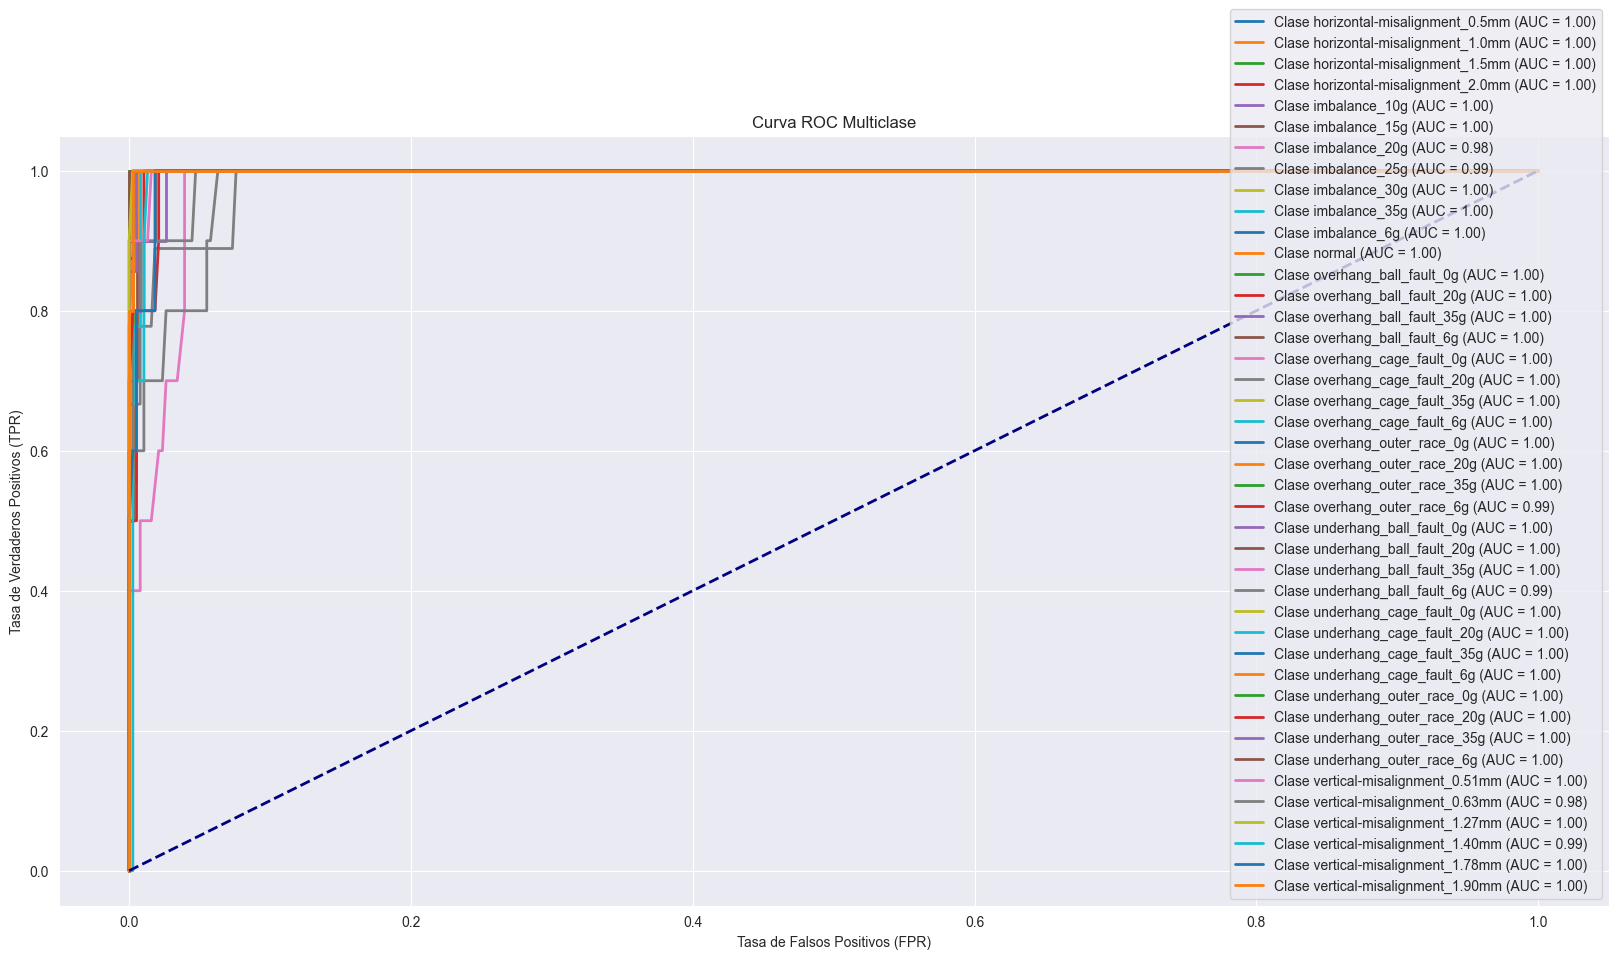

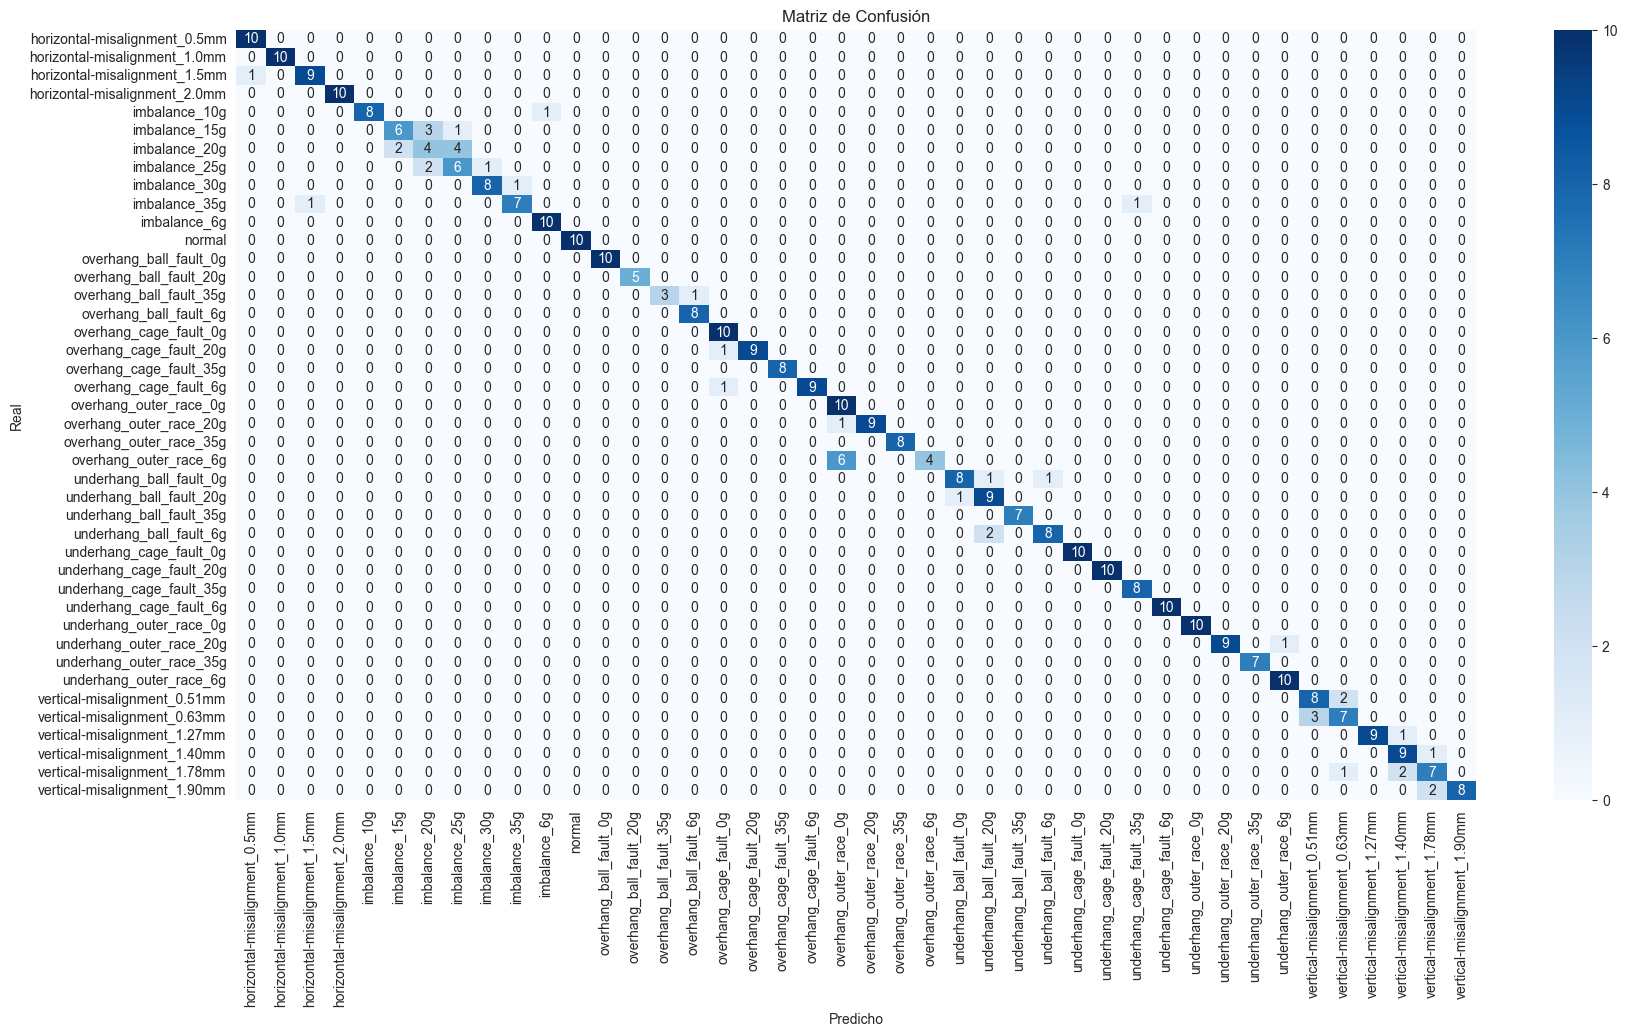

In [24]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

La accuracy baja 0.04

##### Quitamos 'acc_over_axial'  

In [29]:
datos = pd.read_csv('Data_final.csv')

In [30]:
X = datos.iloc[:, :-1]
y = datos.iloc[:, -1]

In [31]:
columnas_a_quitar = generar_nombres_columnas('acc_under_axial')
print(columnas_a_quitar)

['acc_under_axial_Media', 'acc_under_axial_Var', 'acc_under_axial_Max', 'acc_under_axial_Min', 'acc_under_axial_Rango', 'acc_under_axial_Asimetría', 'acc_under_axial_Curtosis', 'acc_under_axial_Autocorrelación', 'acc_under_axial_Frecuencia_dominante']


In [32]:
X_reducida = X.drop(columns=columnas_a_quitar)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida, y, test_size=0.2, random_state=42, stratify=y)
rf_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       0.91      1.00      0.95        10
horizontal-misalignment_1.0mm       1.00      0.90      0.95        10
horizontal-misalignment_1.5mm       1.00      1.00      1.00        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      1.00      1.00         9
                imbalance_15g       0.89      0.80      0.84        10
                imbalance_20g       0.80      0.80      0.80        10
                imbalance_25g       0.89      0.89      0.89         9
                imbalance_30g       0.89      0.89      0.89         9
                imbalance_35g       0.89      0.89      0.89         9
                 imbalance_6g       1.00      1.00      1.00        10
                       normal       1.00      1.00      1.00        10
       overhang_ball_fault_0g       0.91      1.00      0.95        10
     

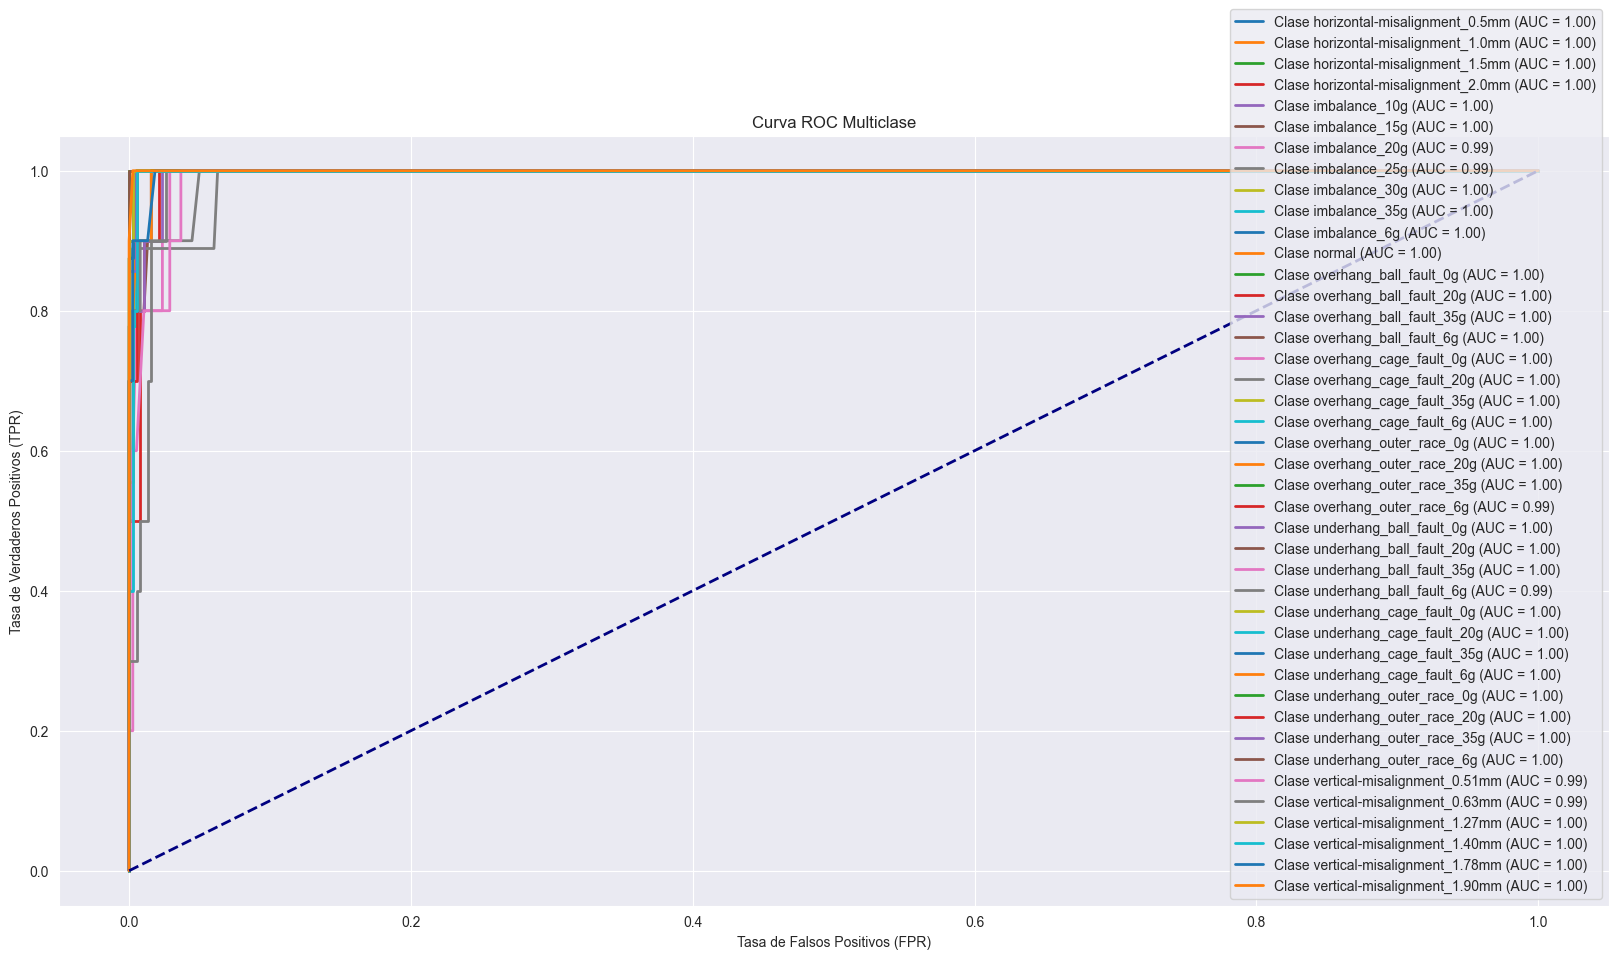

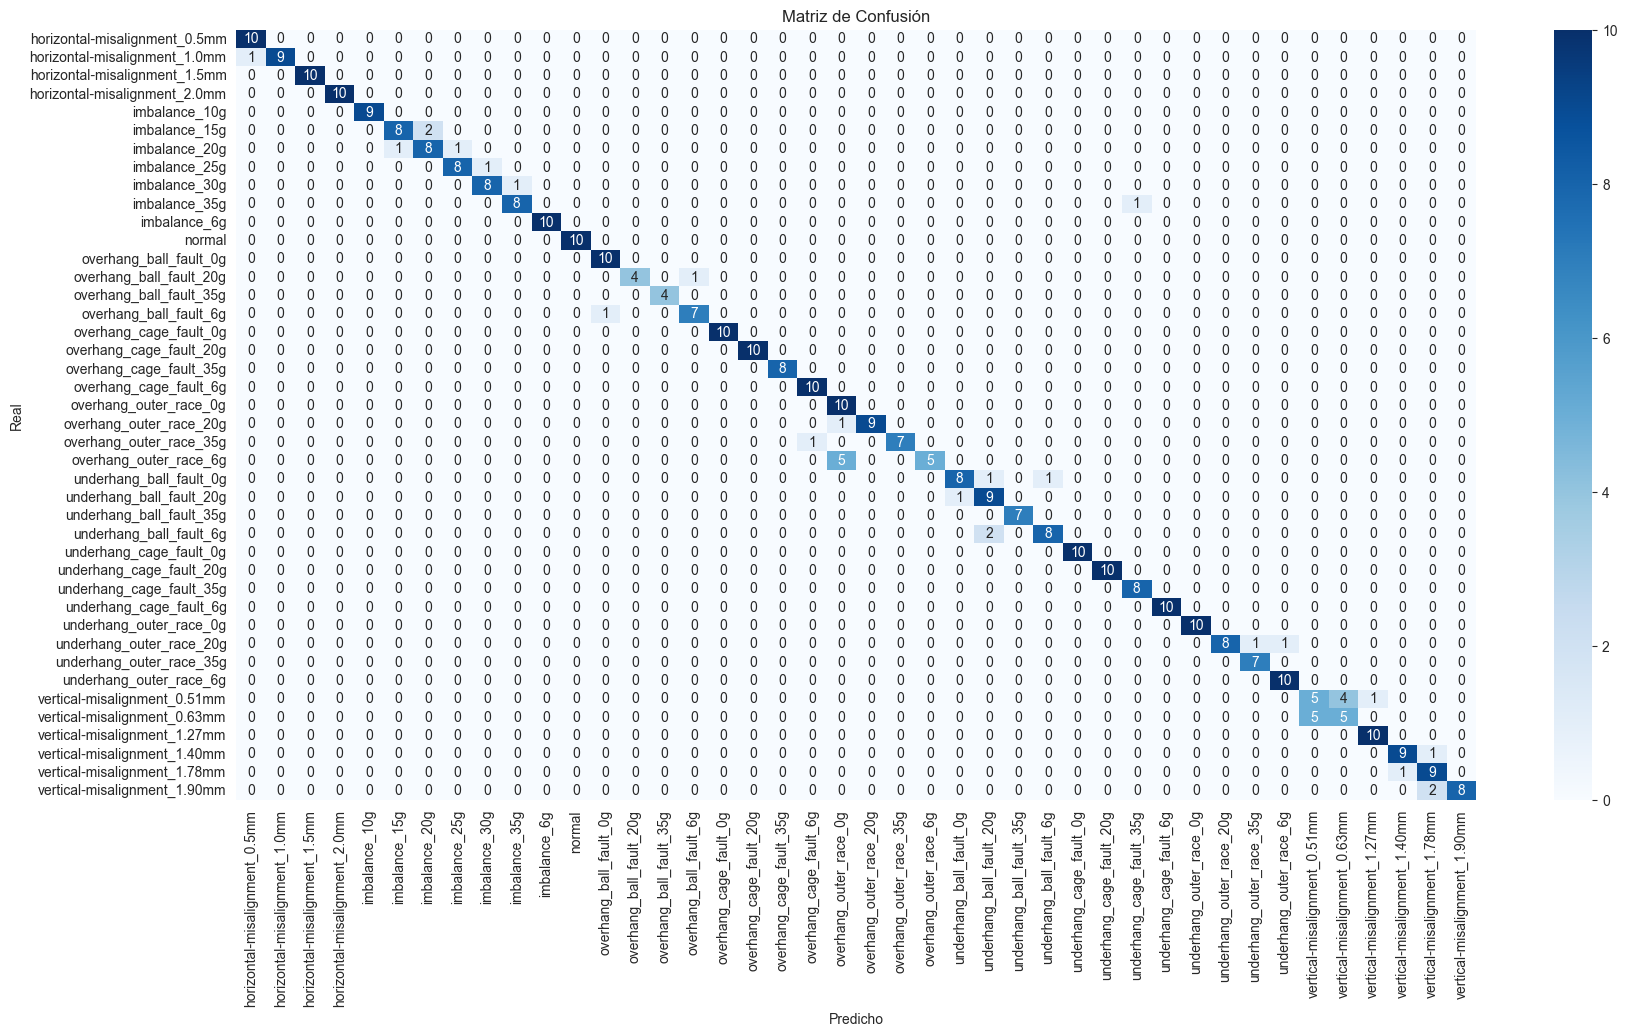

In [34]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

La accuracy baja 0.02

 ##### Quitamos 'acc_over_radiale' 

In [35]:
datos = pd.read_csv('Data_final.csv')

In [36]:
X = datos.iloc[:, :-1]
y = datos.iloc[:, -1]

In [37]:
columnas_a_quitar = generar_nombres_columnas('acc_over_radiale')
print(columnas_a_quitar)

['acc_over_radiale_Media', 'acc_over_radiale_Var', 'acc_over_radiale_Max', 'acc_over_radiale_Min', 'acc_over_radiale_Rango', 'acc_over_radiale_Asimetría', 'acc_over_radiale_Curtosis', 'acc_over_radiale_Autocorrelación', 'acc_over_radiale_Frecuencia_dominante']


In [38]:
X_reducida = X.drop(columns=columnas_a_quitar)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida, y, test_size=0.2, random_state=42, stratify=y)

In [40]:
rf_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       1.00      1.00      1.00        10
horizontal-misalignment_1.0mm       0.91      1.00      0.95        10
horizontal-misalignment_1.5mm       1.00      0.90      0.95        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      1.00      1.00         9
                imbalance_15g       0.89      0.80      0.84        10
                imbalance_20g       0.80      0.80      0.80        10
                imbalance_25g       0.80      0.89      0.84         9
                imbalance_30g       0.88      0.78      0.82         9
                imbalance_35g       0.89      0.89      0.89         9
                 imbalance_6g       1.00      1.00      1.00        10
                       normal       1.00      1.00      1.00        10
       overhang_ball_fault_0g       1.00      1.00      1.00        10
     

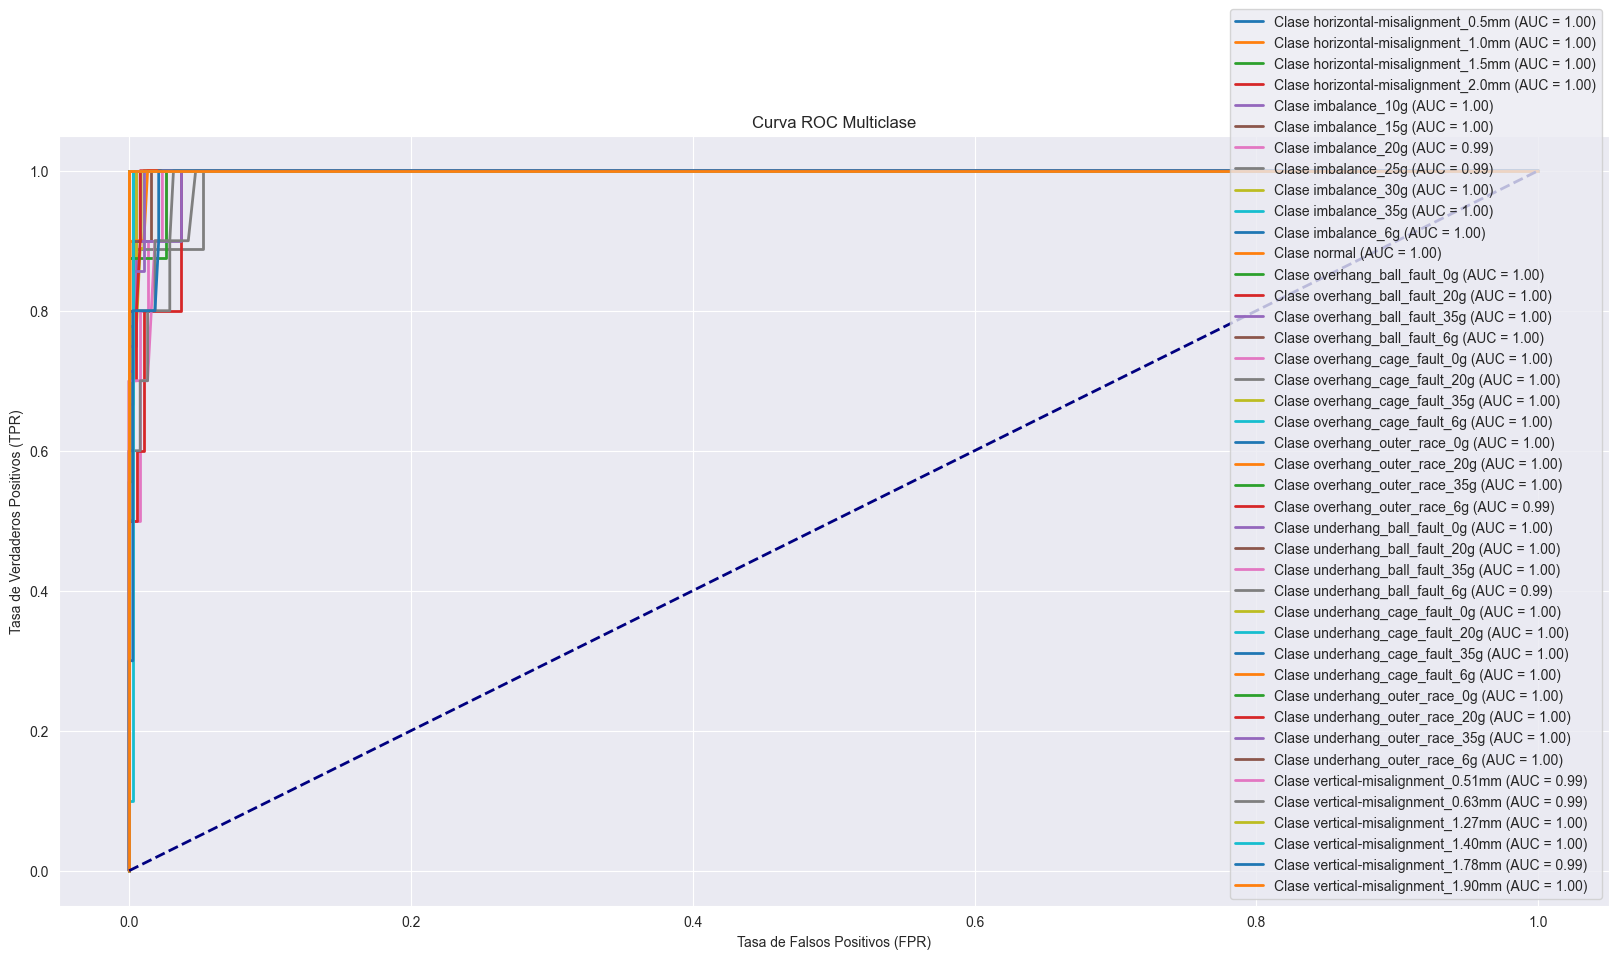

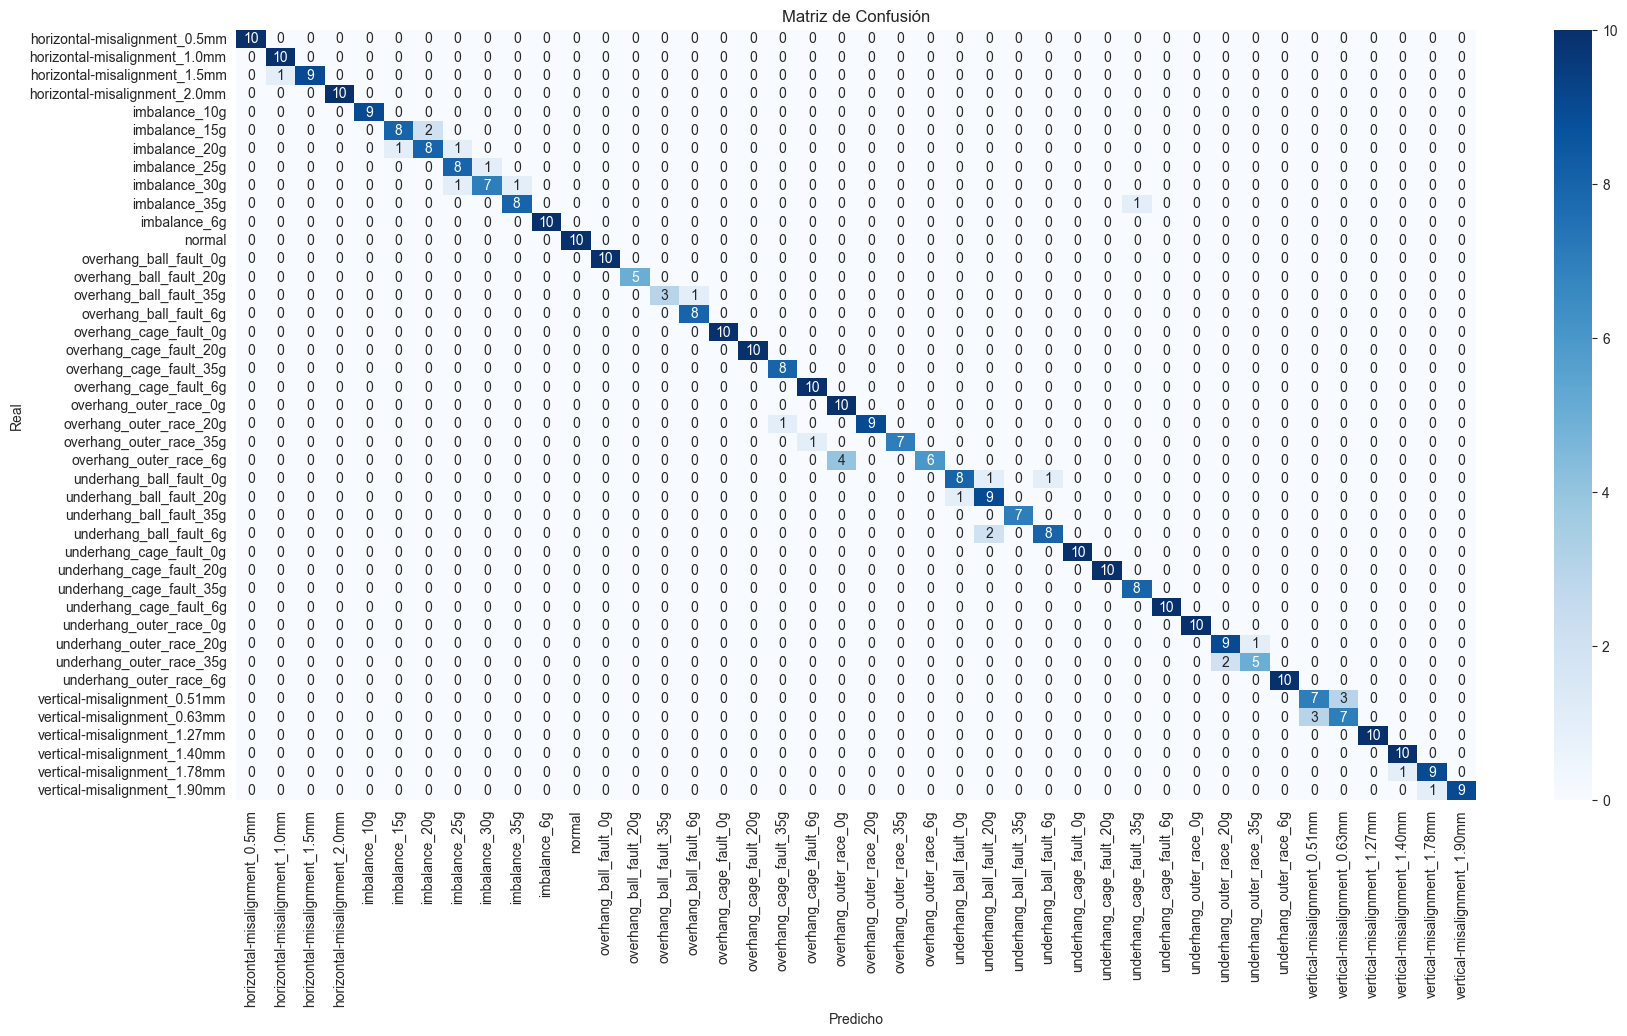

In [41]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

La accuracy se mantiene, podriamos quitarlo

 ##### Quitamos 'acc_over_tangencial'  

In [42]:
datos = pd.read_csv('Data_final.csv')

In [43]:
X = datos.iloc[:, :-1]
y = datos.iloc[:, -1]

In [44]:
columnas_a_quitar = generar_nombres_columnas('acc_over_tangencial')
print(columnas_a_quitar)

['acc_over_tangencial_Media', 'acc_over_tangencial_Var', 'acc_over_tangencial_Max', 'acc_over_tangencial_Min', 'acc_over_tangencial_Rango', 'acc_over_tangencial_Asimetría', 'acc_over_tangencial_Curtosis', 'acc_over_tangencial_Autocorrelación', 'acc_over_tangencial_Frecuencia_dominante']


In [45]:
X_reducida = X.drop(columns=columnas_a_quitar)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
rf_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       0.91      1.00      0.95        10
horizontal-misalignment_1.0mm       1.00      0.90      0.95        10
horizontal-misalignment_1.5mm       1.00      1.00      1.00        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      1.00      1.00         9
                imbalance_15g       1.00      0.80      0.89        10
                imbalance_20g       0.82      0.90      0.86        10
                imbalance_25g       0.89      0.89      0.89         9
                imbalance_30g       0.89      0.89      0.89         9
                imbalance_35g       0.89      0.89      0.89         9
                 imbalance_6g       1.00      1.00      1.00        10
                       normal       1.00      1.00      1.00        10
       overhang_ball_fault_0g       0.91      1.00      0.95        10
     

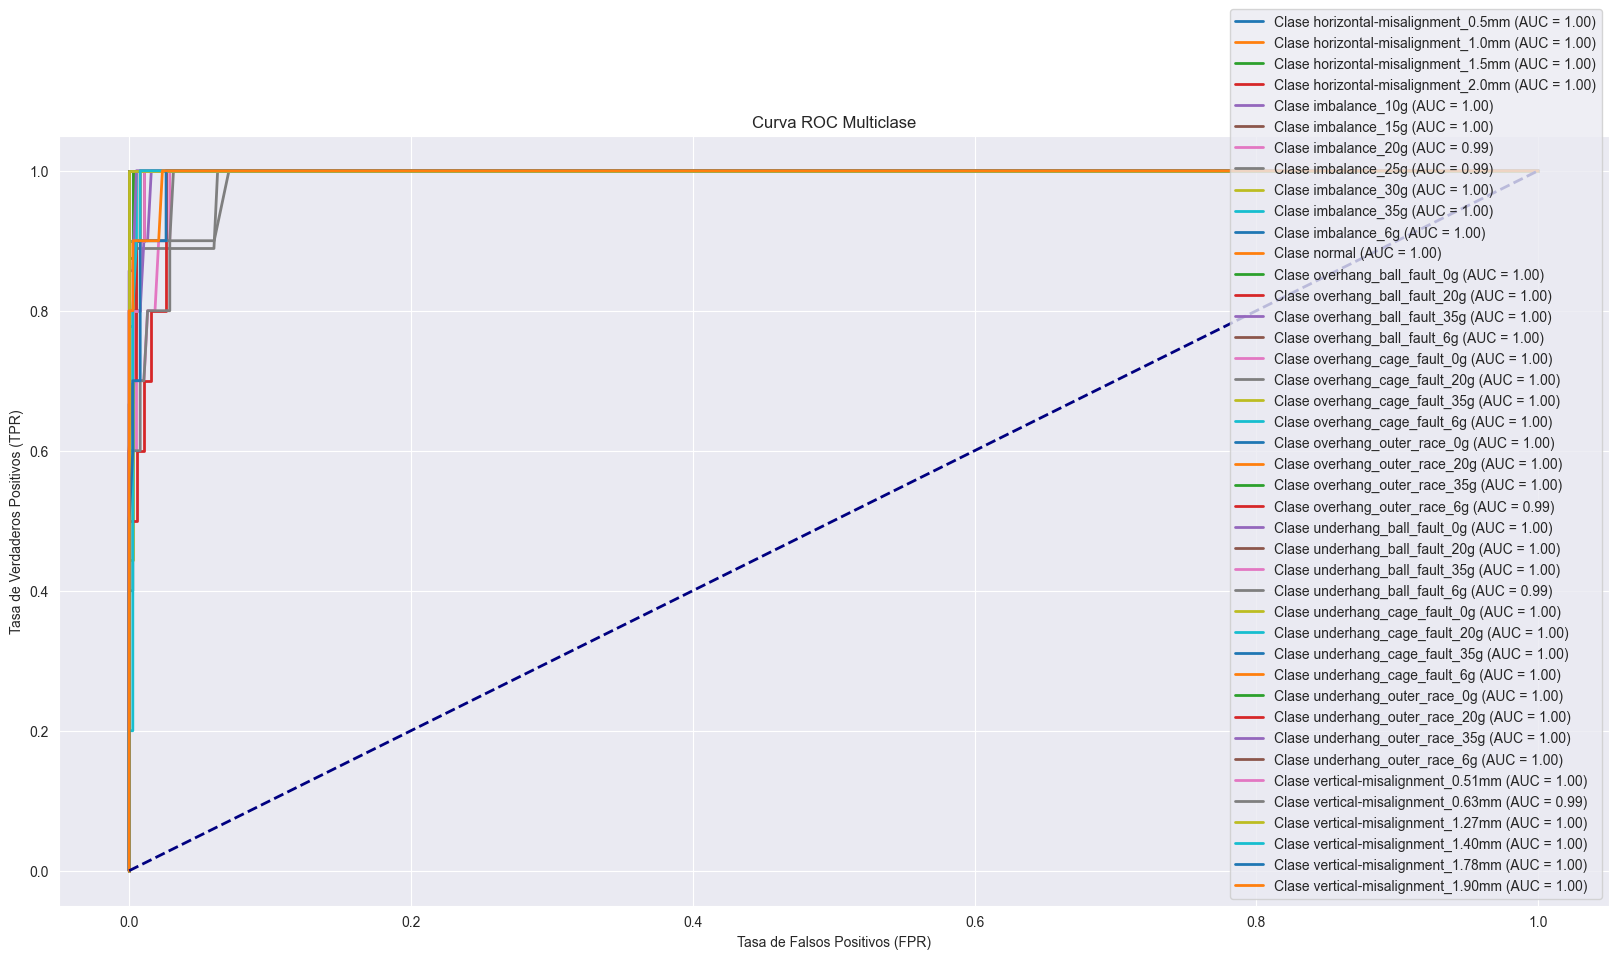

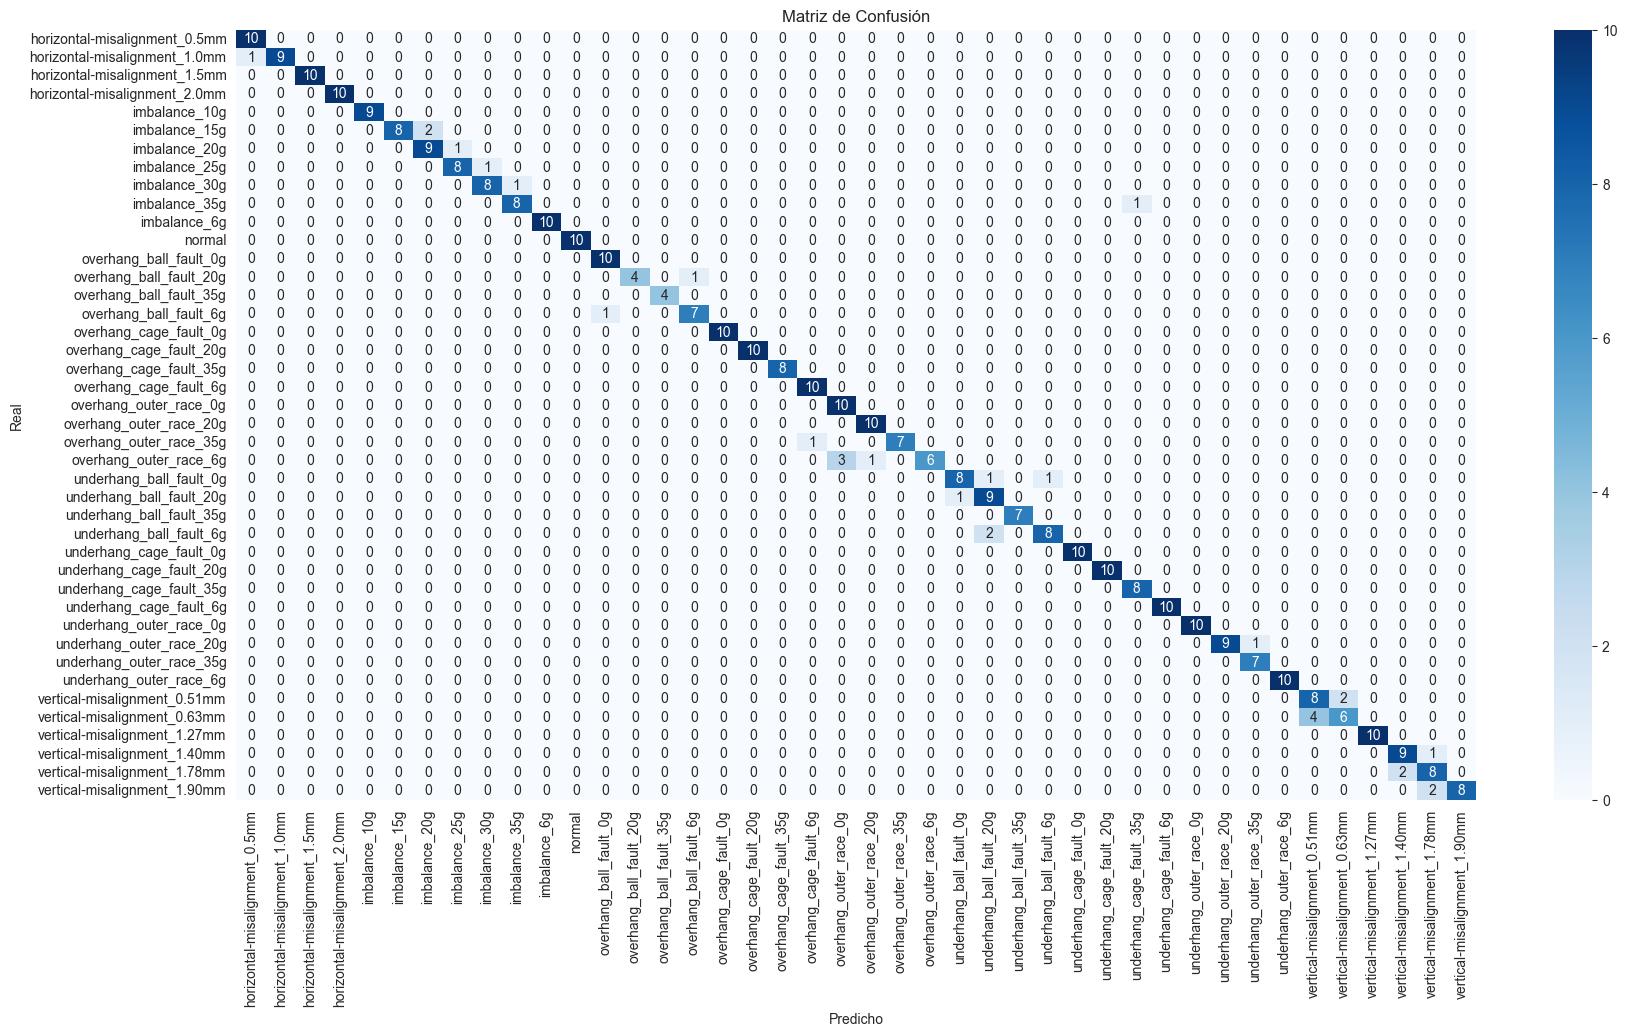

In [48]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

La accuracy se mantiene, podríamos quitarlo también

 ##### Quitamos 'microphone' 

In [49]:
datos = pd.read_csv('Data_final.csv')

In [50]:
X = datos.iloc[:, :-1]
y = datos.iloc[:, -1]

In [51]:
columnas_a_quitar = generar_nombres_columnas('microphone')
print(columnas_a_quitar)

['microphone_Media', 'microphone_Var', 'microphone_Max', 'microphone_Min', 'microphone_Rango', 'microphone_Asimetría', 'microphone_Curtosis', 'microphone_Autocorrelación', 'microphone_Frecuencia_dominante']


In [52]:
X_reducida = X.drop(columns=columnas_a_quitar)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida, y, test_size=0.2, random_state=42, stratify=y)

In [54]:
rf_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       1.00      1.00      1.00        10
horizontal-misalignment_1.0mm       1.00      1.00      1.00        10
horizontal-misalignment_1.5mm       1.00      1.00      1.00        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      1.00      1.00         9
                imbalance_15g       0.83      0.50      0.62        10
                imbalance_20g       0.62      0.80      0.70        10
                imbalance_25g       0.78      0.78      0.78         9
                imbalance_30g       0.90      1.00      0.95         9
                imbalance_35g       1.00      0.89      0.94         9
                 imbalance_6g       1.00      1.00      1.00        10
                       normal       1.00      1.00      1.00        10
       overhang_ball_fault_0g       0.77      1.00      0.87        10
     

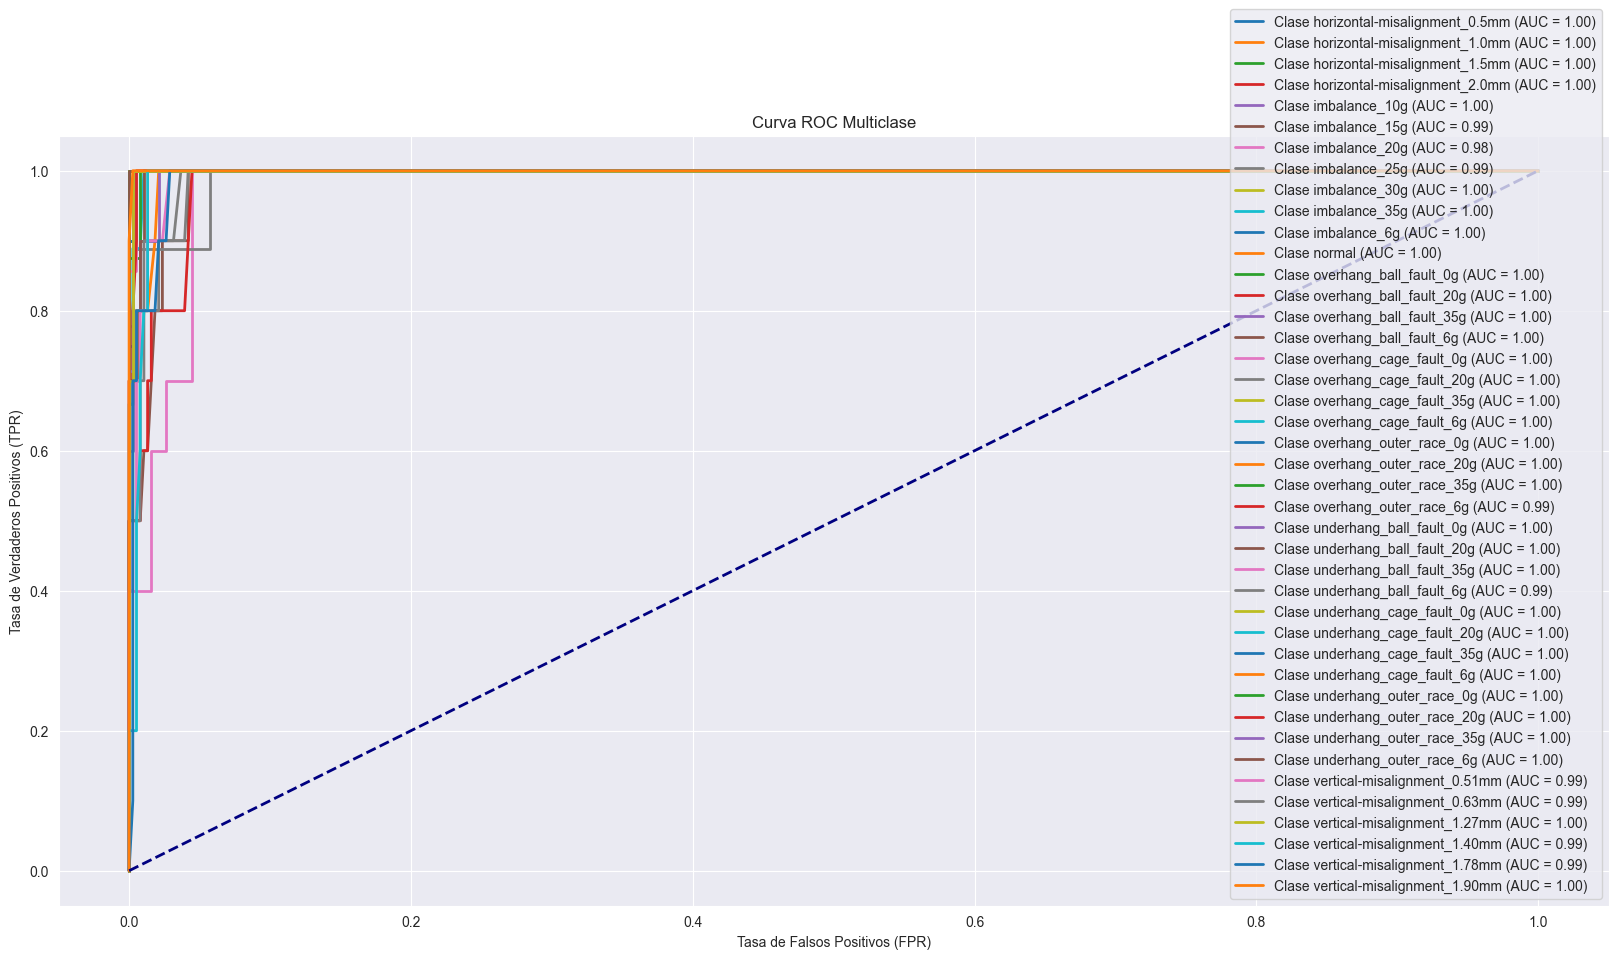

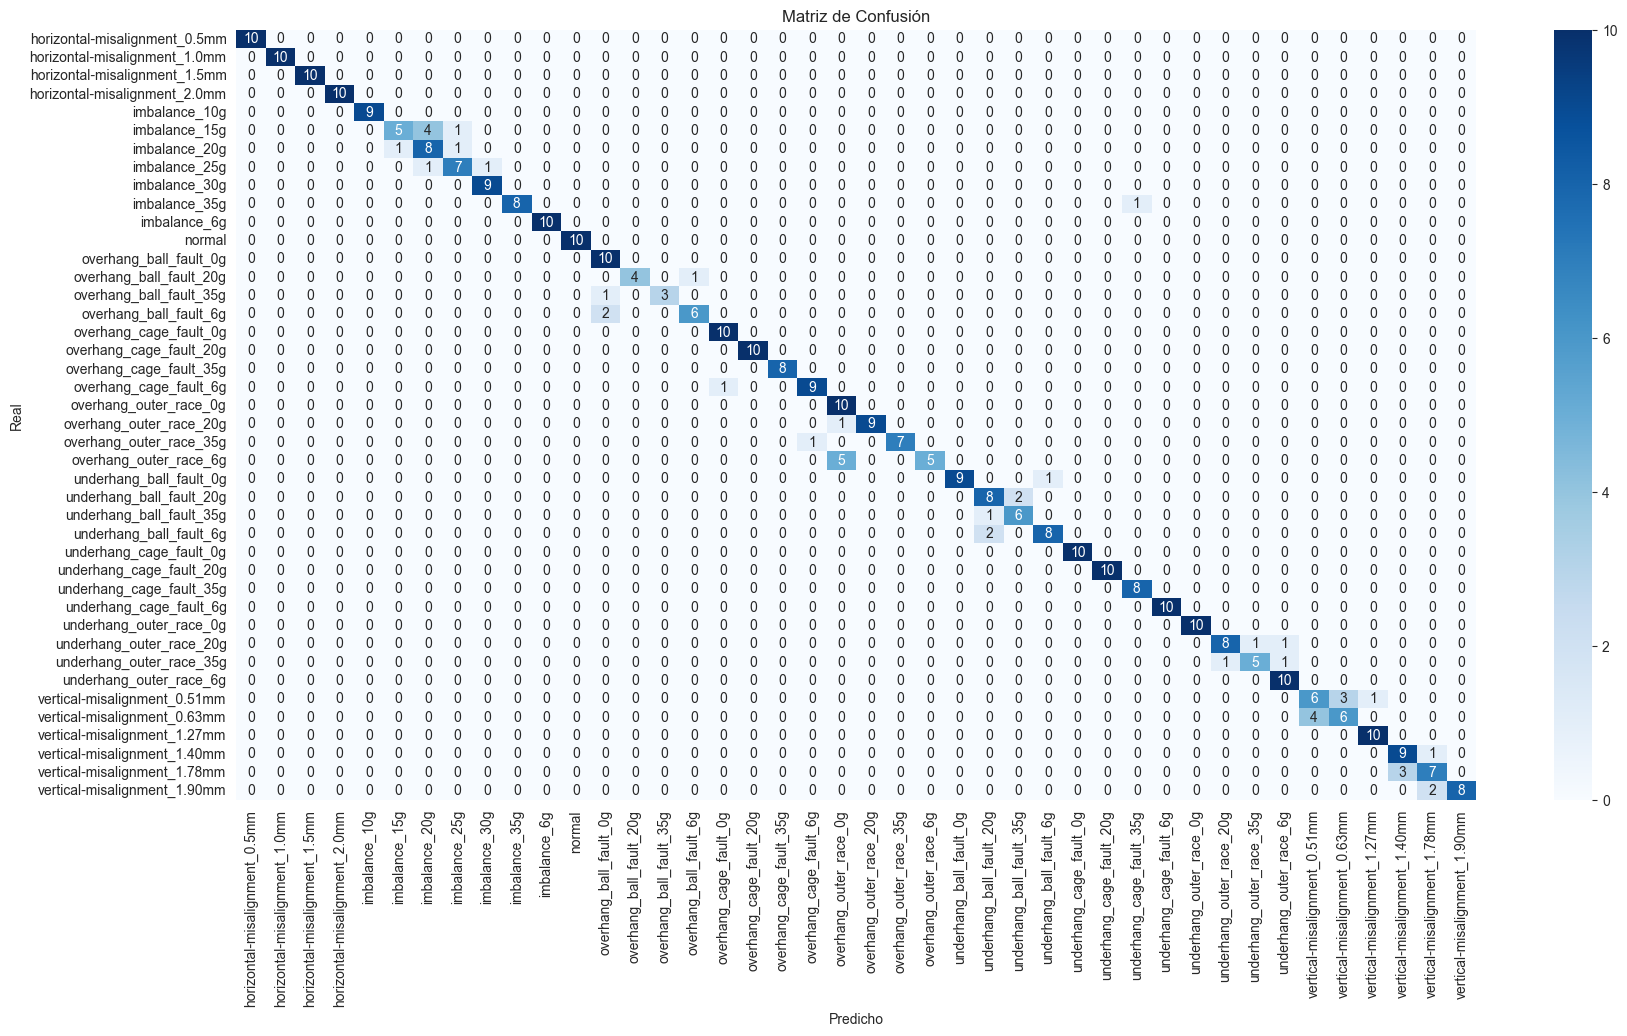

In [55]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Baja 0.04

#### Vamos a quitar los que hemos visto que no influyen a la clasificacion

Quitamos 'acc_over_radiale', 'acc_over_tangencial' y 'tachometer'

In [6]:
def generar_nombres_columnas(column):
    return [
        f'{column}_Media', 
        f'{column}_Var', 
        f'{column}_Max', 
        f'{column}_Min', 
        f'{column}_Rango',
        f'{column}_Asimetría', 
        f'{column}_Curtosis', 
        f'{column}_Autocorrelación', 
        f'{column}_Frecuencia_dominante'
    ]

In [3]:
datos = pd.read_csv('Data_final.csv')

In [4]:
X = datos.iloc[:, :-1]
y = datos.iloc[:, -1]

In [7]:
columnas_a_quitar1 = generar_nombres_columnas('acc_over_radiale')
columnas_a_quitar2 = generar_nombres_columnas('acc_over_tangencial')
columnas_a_quitar3 = generar_nombres_columnas('tachometer')
columnas_a_quitar = columnas_a_quitar1 + columnas_a_quitar2 + columnas_a_quitar3
print(columnas_a_quitar)

['acc_over_radiale_Media', 'acc_over_radiale_Var', 'acc_over_radiale_Max', 'acc_over_radiale_Min', 'acc_over_radiale_Rango', 'acc_over_radiale_Asimetría', 'acc_over_radiale_Curtosis', 'acc_over_radiale_Autocorrelación', 'acc_over_radiale_Frecuencia_dominante', 'acc_over_tangencial_Media', 'acc_over_tangencial_Var', 'acc_over_tangencial_Max', 'acc_over_tangencial_Min', 'acc_over_tangencial_Rango', 'acc_over_tangencial_Asimetría', 'acc_over_tangencial_Curtosis', 'acc_over_tangencial_Autocorrelación', 'acc_over_tangencial_Frecuencia_dominante', 'tachometer_Media', 'tachometer_Var', 'tachometer_Max', 'tachometer_Min', 'tachometer_Rango', 'tachometer_Asimetría', 'tachometer_Curtosis', 'tachometer_Autocorrelación', 'tachometer_Frecuencia_dominante']


In [8]:
X_reducida = X.drop(columns=columnas_a_quitar)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
rf_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       1.00      1.00      1.00        10
horizontal-misalignment_1.0mm       1.00      1.00      1.00        10
horizontal-misalignment_1.5mm       1.00      1.00      1.00        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      1.00      1.00         9
                imbalance_15g       0.90      0.90      0.90        10
                imbalance_20g       0.89      0.80      0.84        10
                imbalance_25g       0.89      0.89      0.89         9
                imbalance_30g       0.89      0.89      0.89         9
                imbalance_35g       0.89      0.89      0.89         9
                 imbalance_6g       1.00      1.00      1.00        10
                       normal       1.00      1.00      1.00        10
       overhang_ball_fault_0g       1.00      1.00      1.00        10
     

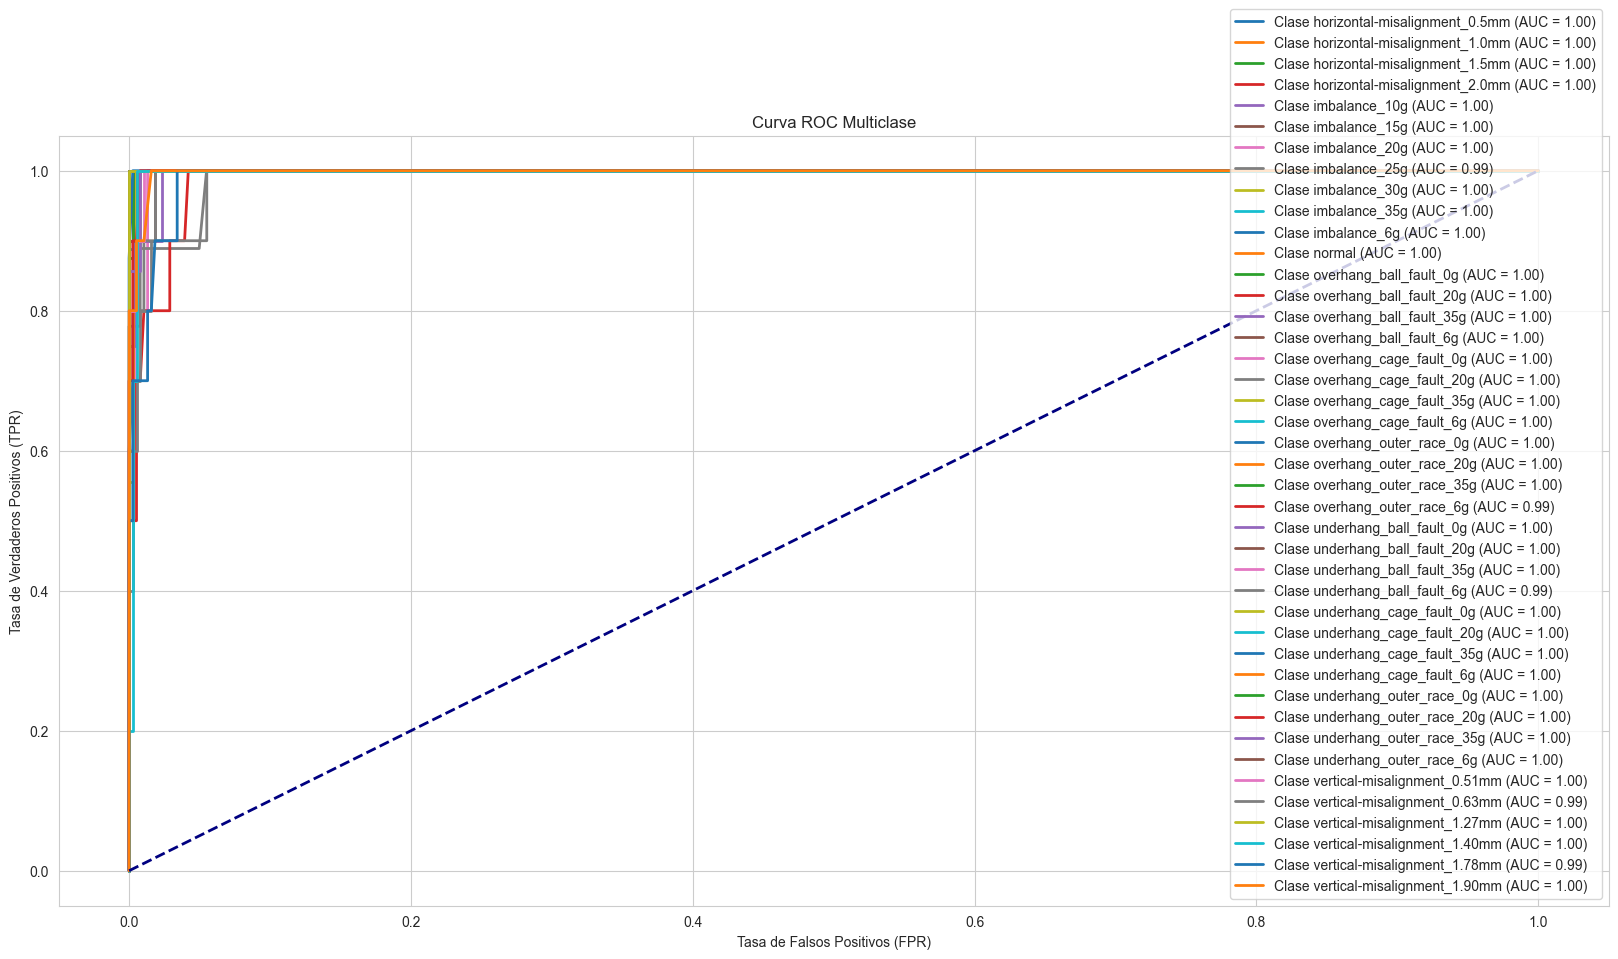

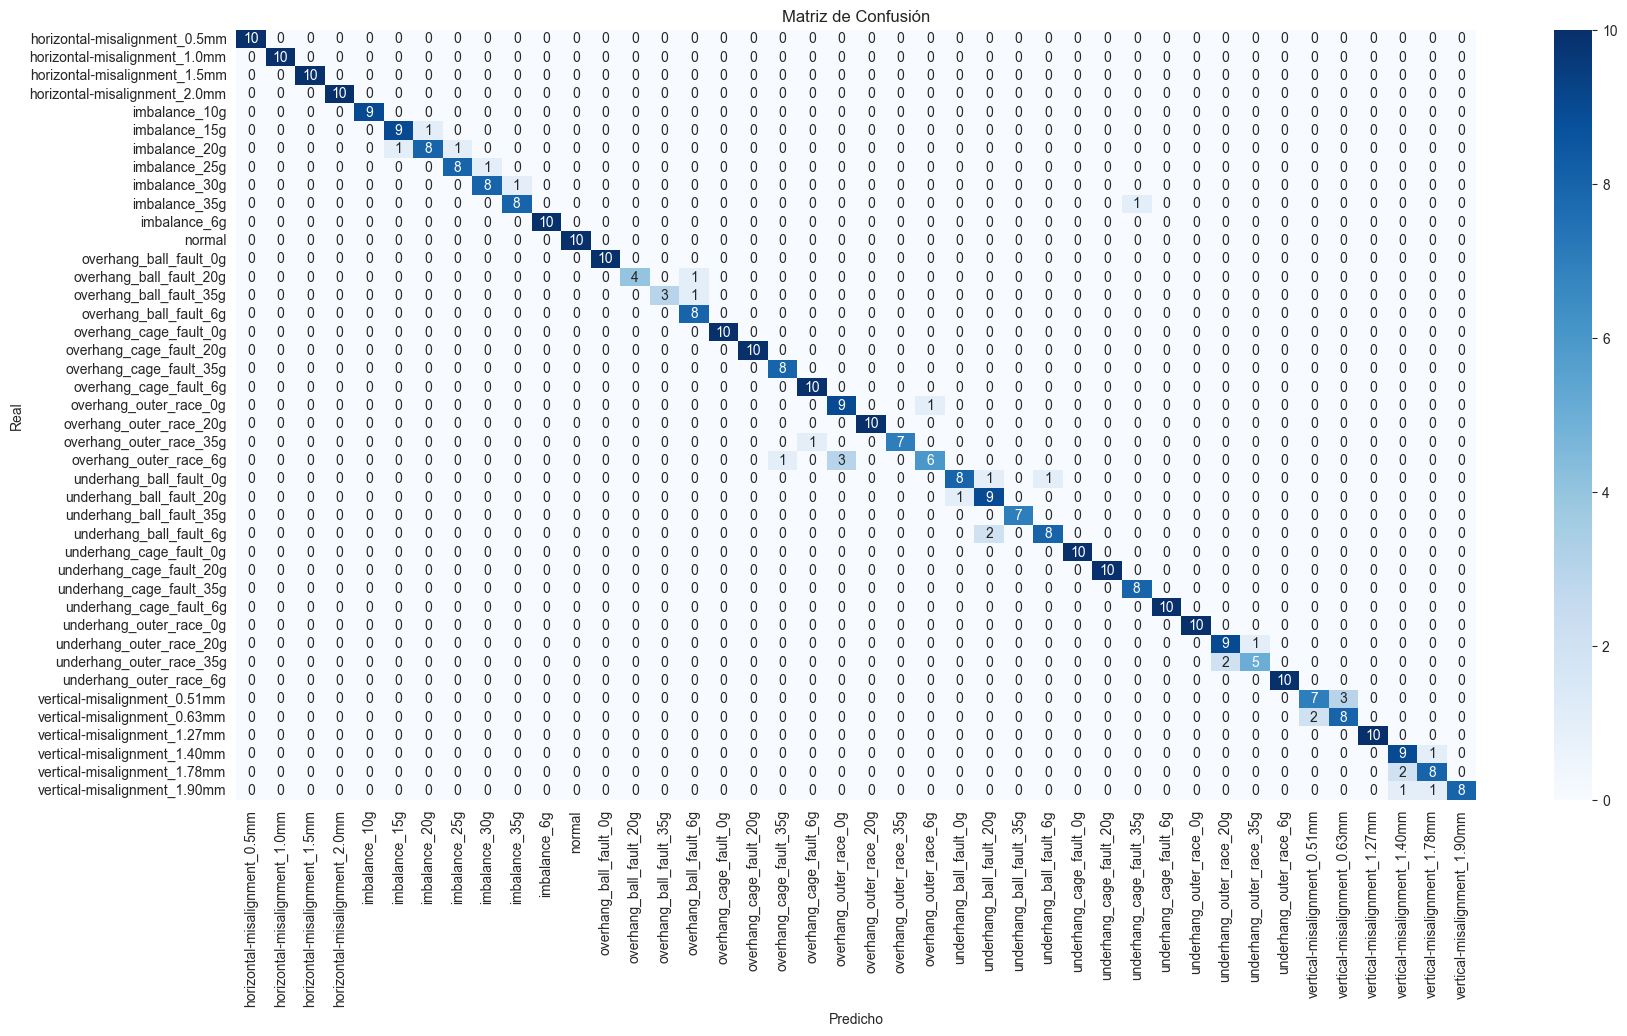

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Practicamente mismas métricas con 3 sensores menos. 

In [12]:
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(15, 10))
    sns.barplot(data=importances, x='importance', y='feature', color='skyblue')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return importances


Feature Importance Analysis:


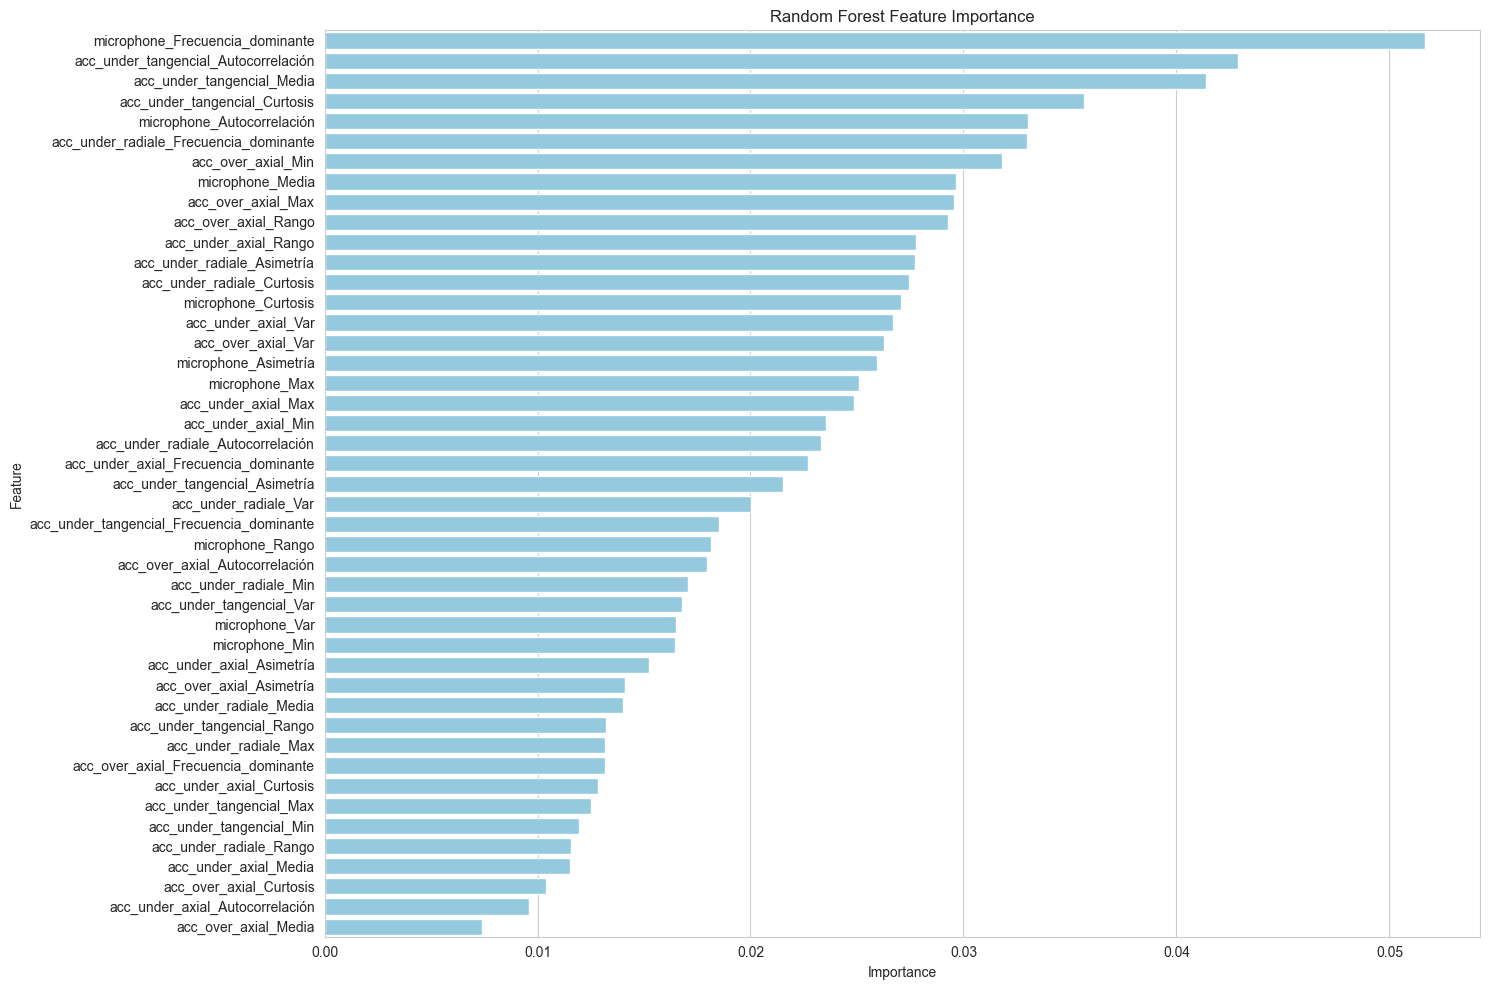


Feature Importance Ranking:
                                      feature  importance
44            microphone_Frecuencia_dominante    0.051669
25       acc_under_tangencial_Autocorrelación    0.042892
18                 acc_under_tangencial_Media    0.041374
24              acc_under_tangencial_Curtosis    0.035645
43                 microphone_Autocorrelación    0.033010
17     acc_under_radiale_Frecuencia_dominante    0.033000
30                         acc_over_axial_Min    0.031817
36                           microphone_Media    0.029633
29                         acc_over_axial_Max    0.029569
31                       acc_over_axial_Rango    0.029274
4                       acc_under_axial_Rango    0.027780
14                acc_under_radiale_Asimetría    0.027718
15                 acc_under_radiale_Curtosis    0.027448
42                        microphone_Curtosis    0.027088
1                         acc_under_axial_Var    0.026700
28                         acc_over_axial_V

In [13]:
print("\nFeature Importance Analysis:")
importance_df = plot_feature_importance(rf_model, X_reducida.columns,
                                     "Random Forest Feature Importance")
print("\nFeature Importance Ranking:")
print(importance_df)

Combinamos los dos enfoques. Quitamos las de menor importancia

In [15]:
X_reducida2 = X_reducida.drop(columns=['acc_under_axial_Autocorrelación', 'acc_over_axial_Media'])
X_train, X_test, y_train, y_test = train_test_split(X_reducida2, y, test_size=0.2, random_state=42, stratify=y)

##### Random Forest

In [16]:
rf_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=200)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       1.00      1.00      1.00        10
horizontal-misalignment_1.0mm       1.00      1.00      1.00        10
horizontal-misalignment_1.5mm       1.00      1.00      1.00        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       1.00      1.00      1.00         9
                imbalance_15g       0.90      0.90      0.90        10
                imbalance_20g       0.89      0.80      0.84        10
                imbalance_25g       0.89      0.89      0.89         9
                imbalance_30g       0.89      0.89      0.89         9
                imbalance_35g       0.89      0.89      0.89         9
                 imbalance_6g       1.00      1.00      1.00        10
                       normal       0.91      1.00      0.95        10
       overhang_ball_fault_0g       0.91      1.00      0.95        10
     

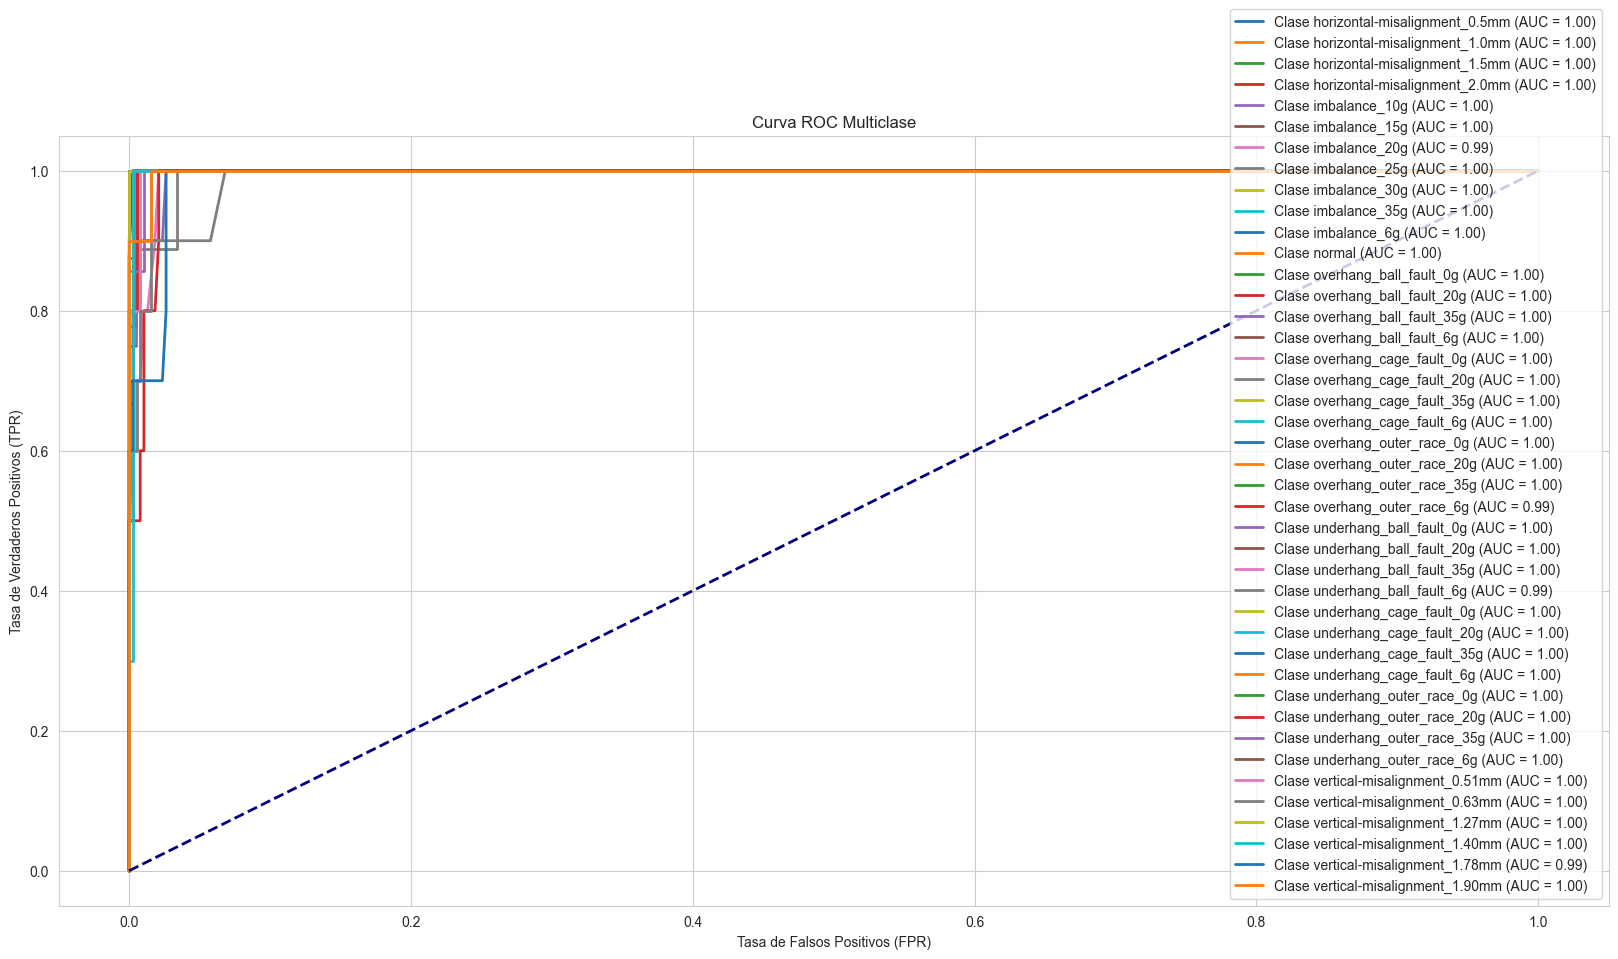

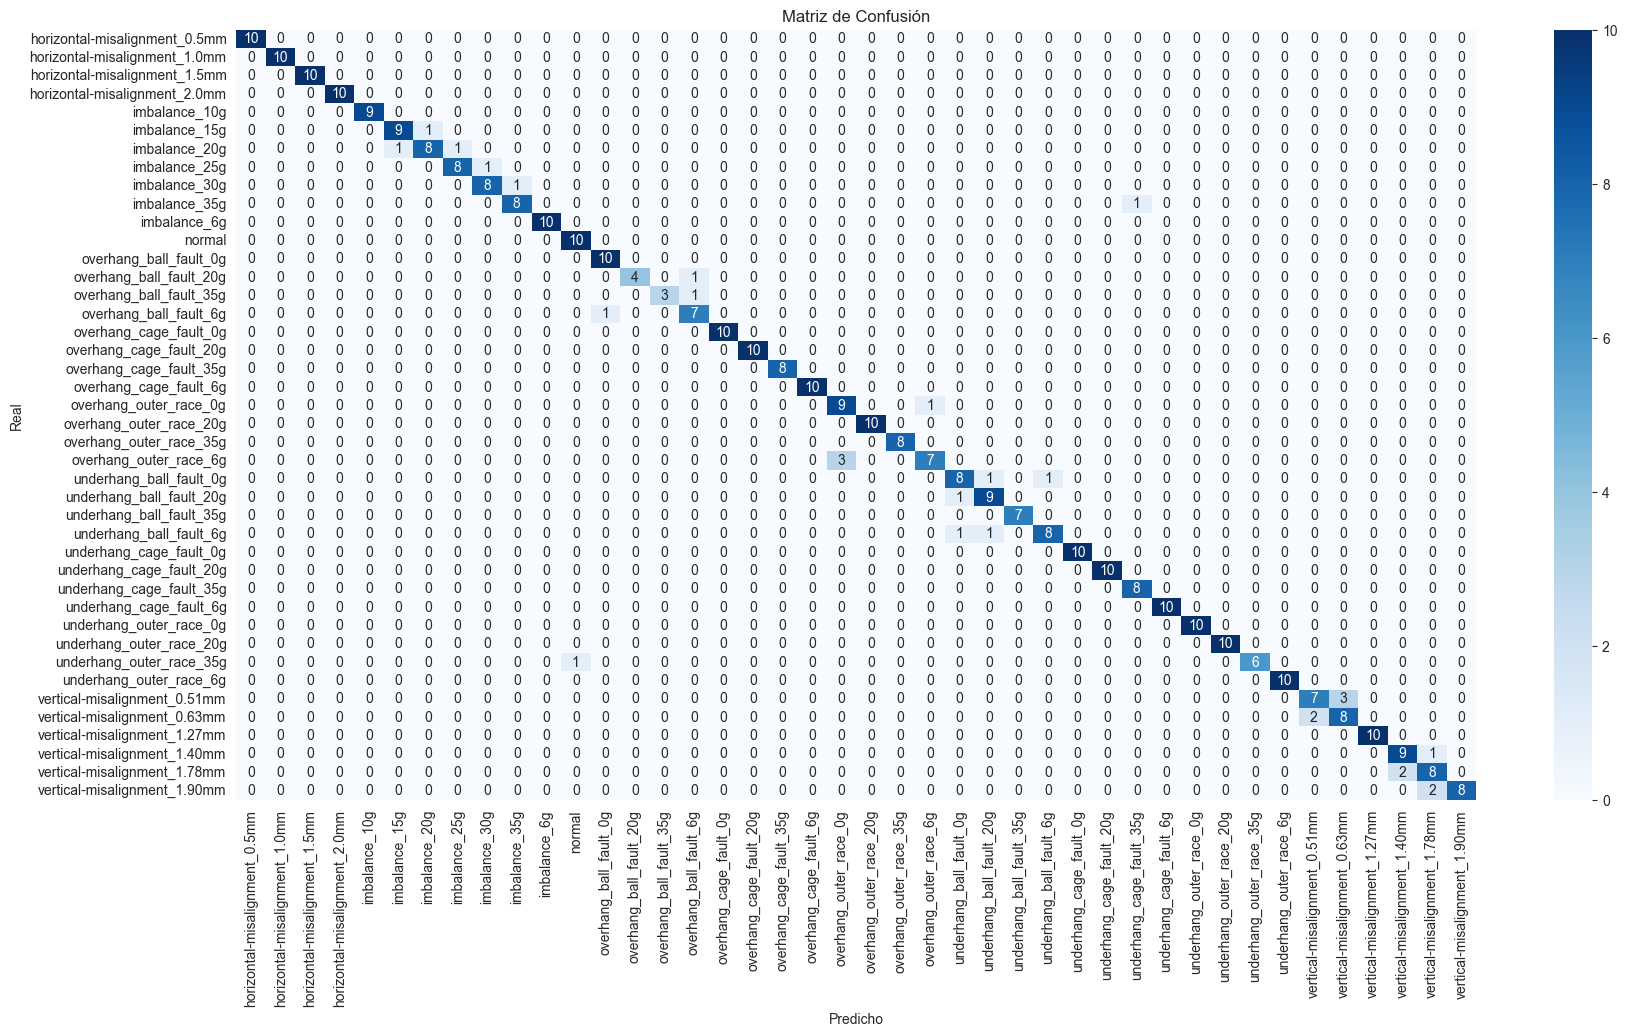

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = rf_model.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Incluso mejores métricas. Este es el modelo final.

Agrupar las clases de un mismo error en la matriz de confusion para facilitar la comprensión

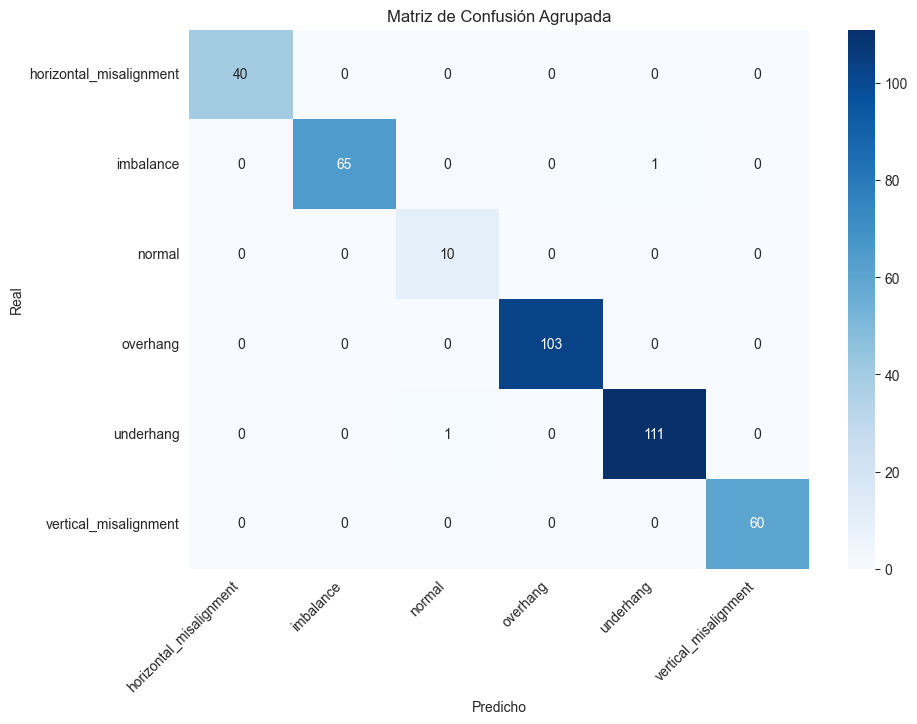

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Grupos definidos
group_mapping = {
    'horizontal-misalignment_0.5mm': 'horizontal_misalignment',
    'horizontal-misalignment_1.0mm': 'horizontal_misalignment',
    'horizontal-misalignment_1.5mm': 'horizontal_misalignment',
    'horizontal-misalignment_2.0mm': 'horizontal_misalignment',
    'vertical-misalignment_0.51mm': 'vertical_misalignment',
    'vertical-misalignment_0.63mm': 'vertical_misalignment',
    'vertical-misalignment_1.27mm': 'vertical_misalignment',
    'vertical-misalignment_1.40mm': 'vertical_misalignment',
    'vertical-misalignment_1.78mm': 'vertical_misalignment',
    'vertical-misalignment_1.90mm': 'vertical_misalignment',
    'imbalance_6g': 'imbalance',
    'imbalance_10g': 'imbalance',
    'imbalance_20g': 'imbalance',
    'imbalance_15g': 'imbalance',
    'imbalance_25g': 'imbalance',
    'imbalance_30g': 'imbalance',
    'imbalance_35g': 'imbalance',
    'overhang_ball_fault_0g': 'overhang',
    'overhang_ball_fault_6g': 'overhang',
    'overhang_ball_fault_20g': 'overhang',
    'overhang_ball_fault_35g': 'overhang',
    'overhang_cage_fault_0g': 'overhang',
    'overhang_cage_fault_6g': 'overhang',
    'overhang_cage_fault_20g': 'overhang',
    'overhang_cage_fault_35g': 'overhang',
    'overhang_outer_race_0g': 'overhang',
    'overhang_outer_race_6g': 'overhang',
    'overhang_outer_race_20g': 'overhang',
    'overhang_outer_race_35g': 'overhang',
    'underhang_ball_fault_0g': 'underhang',
    'underhang_ball_fault_6g': 'underhang',
    'underhang_ball_fault_20g': 'underhang',
    'underhang_ball_fault_35g': 'underhang',
    'underhang_cage_fault_0g': 'underhang',
    'underhang_cage_fault_6g': 'underhang',
    'underhang_cage_fault_20g': 'underhang',
    'underhang_cage_fault_35g': 'underhang',
    'underhang_outer_race_0g': 'underhang',
    'underhang_outer_race_6g': 'underhang',
    'underhang_outer_race_20g': 'underhang',
    'underhang_outer_race_35g': 'underhang',
    'normal': 'normal'
}

# Reasignar etiquetas
y_test_grouped = [group_mapping[label] for label in y_test]
y_pred_grouped = [group_mapping[label] for label in y_pred]

# Calcular nueva matriz de confusión
grouped_classes = sorted(set(group_mapping.values()))
cm_grouped = confusion_matrix(y_test_grouped, y_pred_grouped, labels=grouped_classes)

# Dibujar matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_grouped, annot=True, fmt='d', cmap='Blues',
            xticklabels=grouped_classes,
            yticklabels=grouped_classes)
plt.title('Matriz de Confusión Agrupada')
plt.xlabel('Predicho')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Real')
plt.show()

In [17]:
with open('rf_model_final.pkl', 'wb') as archivo:
    pickle.dump(rf_model, archivo)

##### XGBoost

In [19]:
# Codificar las etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida2, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [21]:
xgb_clf = XGBClassifier(
    random_state=42,
    n_estimators=410,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.01,
    reg_lambda=1,
    eval_metric='mlogloss',
)

# Entrenar el modelo
xgb_clf.fit(X_train, y_train)

# Hacer predicciones
y_pred = xgb_clf.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.88      0.70      0.78        10
           2       0.89      0.80      0.84        10
           3       1.00      1.00      1.00        10
           4       0.80      0.89      0.84         9
           5       0.83      0.50      0.62        10
           6       0.58      0.70      0.64        10
           7       0.78      0.78      0.78         9
           8       0.88      0.78      0.82         9
           9       0.89      0.89      0.89         9
          10       0.90      0.90      0.90        10
          11       0.71      1.00      0.83        10
          12       0.91      1.00      0.95        10
          13       1.00      0.60      0.75         5
          14       1.00      0.75      0.86         4
          15       0.80      1.00      0.89         8
          16       1.00      0.90      0.95        10
          17       0.91    

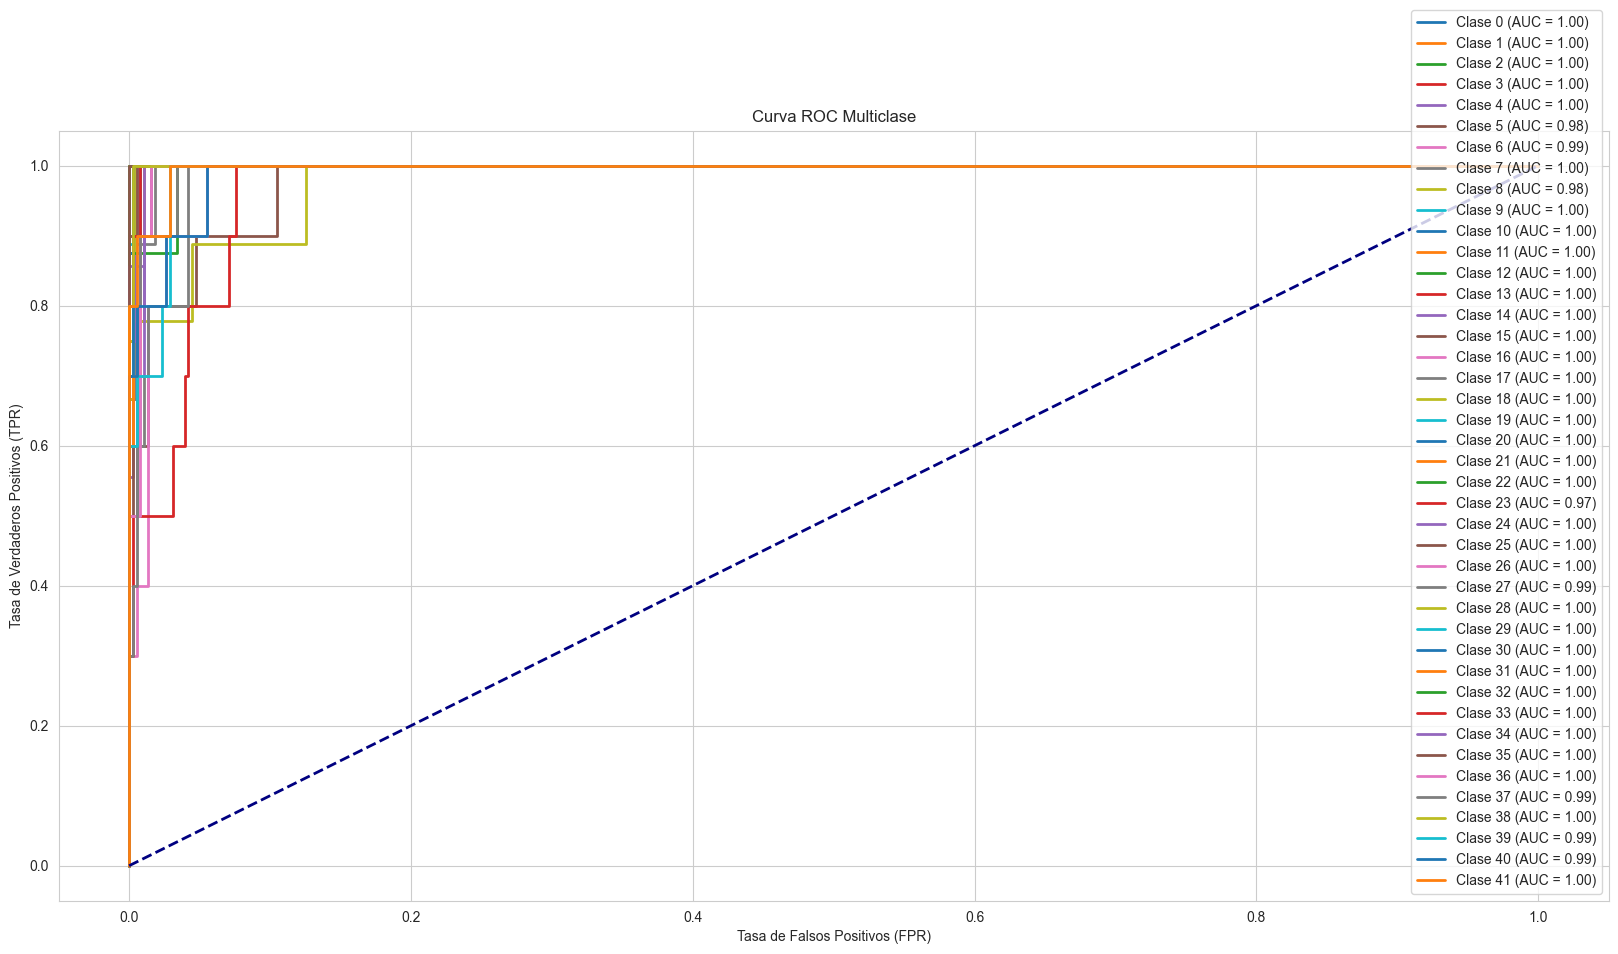

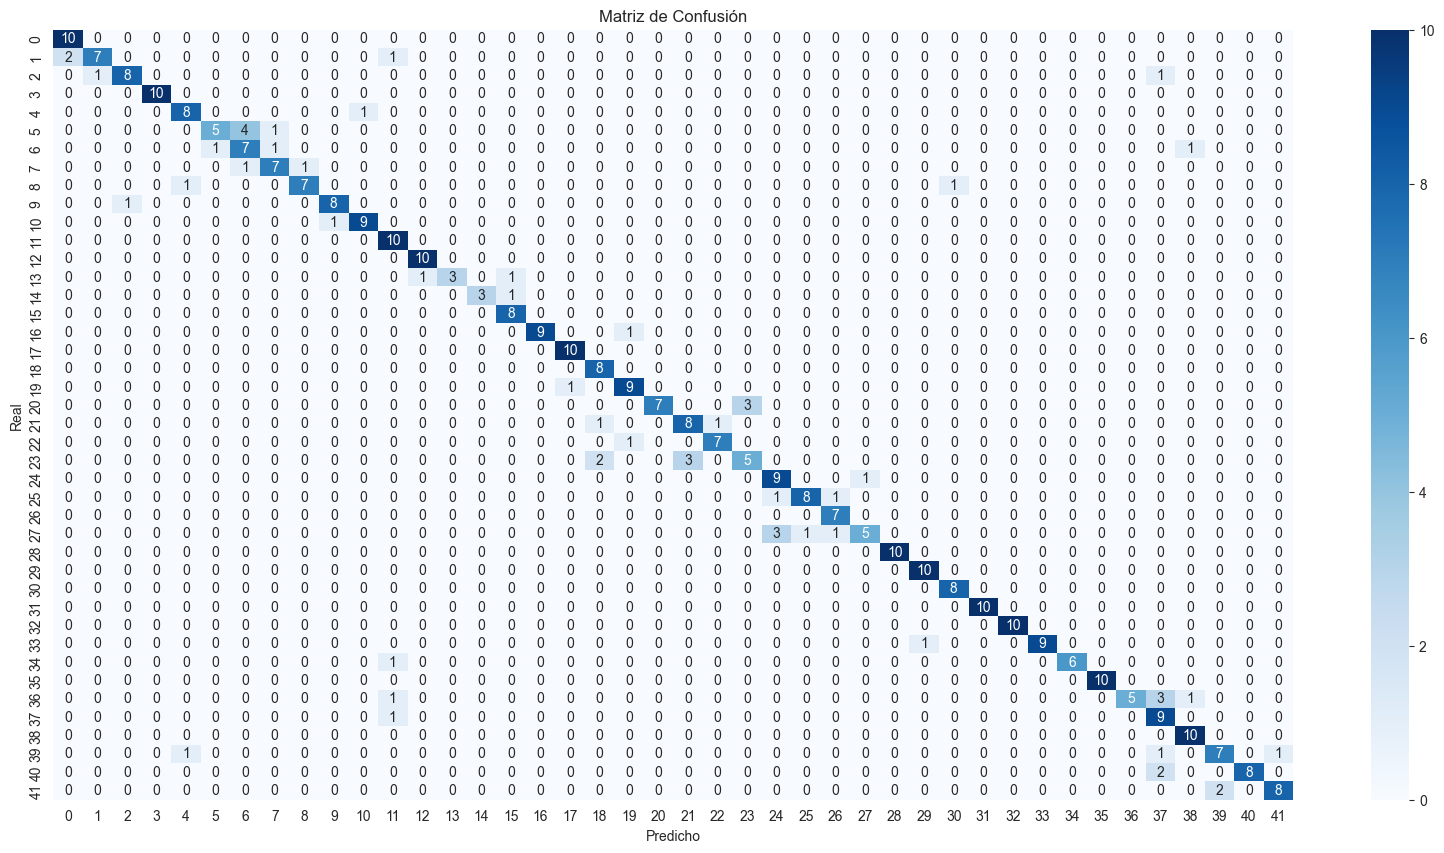

In [22]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = xgb_clf.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


#y_test_decoded = label_encoder.inverse_transform(y_test)  
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [24]:
y_test_decoded = label_encoder.inverse_transform(y_test)  
y_pred_decoded = label_encoder.inverse_transform(y_pred)  

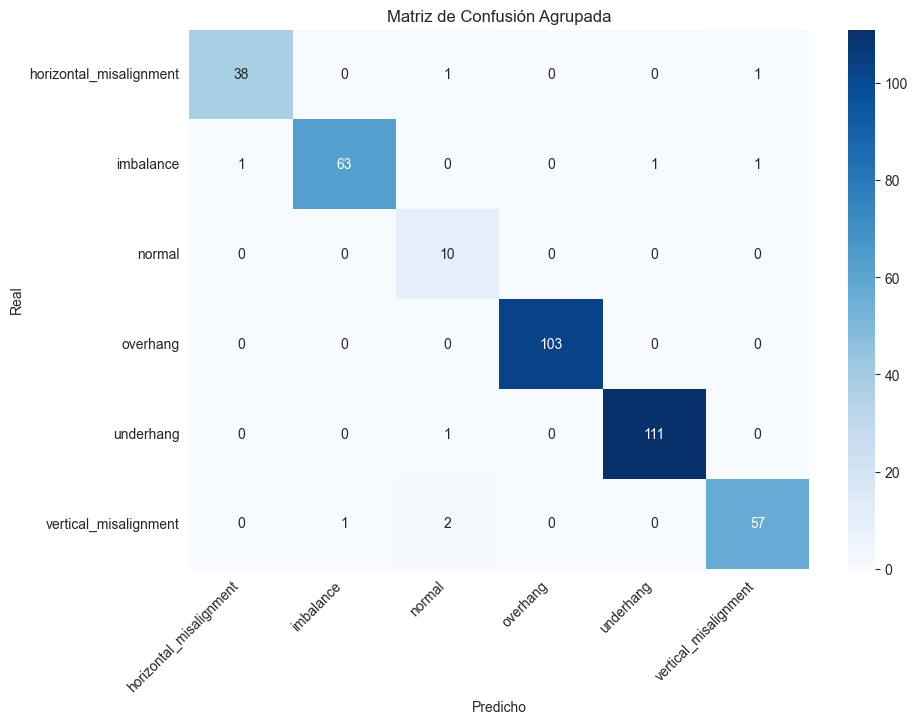

In [25]:
group_mapping = {
    'horizontal-misalignment_0.5mm': 'horizontal_misalignment',
    'horizontal-misalignment_1.0mm': 'horizontal_misalignment',
    'horizontal-misalignment_1.5mm': 'horizontal_misalignment',
    'horizontal-misalignment_2.0mm': 'horizontal_misalignment',
    'vertical-misalignment_0.51mm': 'vertical_misalignment',
    'vertical-misalignment_0.63mm': 'vertical_misalignment',
    'vertical-misalignment_1.27mm': 'vertical_misalignment',
    'vertical-misalignment_1.40mm': 'vertical_misalignment',
    'vertical-misalignment_1.78mm': 'vertical_misalignment',
    'vertical-misalignment_1.90mm': 'vertical_misalignment',
    'imbalance_6g': 'imbalance',
    'imbalance_10g': 'imbalance',
    'imbalance_20g': 'imbalance',
    'imbalance_15g': 'imbalance',
    'imbalance_25g': 'imbalance',
    'imbalance_30g': 'imbalance',
    'imbalance_35g': 'imbalance',
    'overhang_ball_fault_0g': 'overhang',
    'overhang_ball_fault_6g': 'overhang',
    'overhang_ball_fault_20g': 'overhang',
    'overhang_ball_fault_35g': 'overhang',
    'overhang_cage_fault_0g': 'overhang',
    'overhang_cage_fault_6g': 'overhang',
    'overhang_cage_fault_20g': 'overhang',
    'overhang_cage_fault_35g': 'overhang',
    'overhang_outer_race_0g': 'overhang',
    'overhang_outer_race_6g': 'overhang',
    'overhang_outer_race_20g': 'overhang',
    'overhang_outer_race_35g': 'overhang',
    'underhang_ball_fault_0g': 'underhang',
    'underhang_ball_fault_6g': 'underhang',
    'underhang_ball_fault_20g': 'underhang',
    'underhang_ball_fault_35g': 'underhang',
    'underhang_cage_fault_0g': 'underhang',
    'underhang_cage_fault_6g': 'underhang',
    'underhang_cage_fault_20g': 'underhang',
    'underhang_cage_fault_35g': 'underhang',
    'underhang_outer_race_0g': 'underhang',
    'underhang_outer_race_6g': 'underhang',
    'underhang_outer_race_20g': 'underhang',
    'underhang_outer_race_35g': 'underhang',
    'normal': 'normal'
}

# Reasignar etiquetas
y_test_grouped = [group_mapping[label] for label in y_test_decoded]
y_pred_grouped = [group_mapping[label] for label in y_pred_decoded]

# Calcular nueva matriz de confusión
grouped_classes = sorted(set(group_mapping.values()))
cm_grouped = confusion_matrix(y_test_grouped, y_pred_grouped, labels=grouped_classes)

# Dibujar matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_grouped, annot=True, fmt='d', cmap='Blues',
            xticklabels=grouped_classes,
            yticklabels=grouped_classes)
plt.title('Matriz de Confusión Agrupada')
plt.xlabel('Predicho')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Real')
plt.show()

##### Gradient Boosting

In [35]:
datos = pd.read_csv('Data_final.csv')
X = datos.iloc[:, :-1]
y = datos.iloc[:, -1]

In [36]:
columnas_a_quitar1 = generar_nombres_columnas('acc_over_radiale')
columnas_a_quitar2 = generar_nombres_columnas('acc_over_tangencial')
columnas_a_quitar3 = generar_nombres_columnas('tachometer')
columnas_a_quitar = columnas_a_quitar1 + columnas_a_quitar2 + columnas_a_quitar3
X_reducida = X.drop(columns=columnas_a_quitar)

In [37]:
X_reducida2 = X_reducida.drop(columns=['acc_under_axial_Autocorrelación', 'acc_over_axial_Media'])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_reducida2, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
gb_classifier = GradientBoostingClassifier( random_state=42,
                                            n_estimators=150,
                                            max_depth=5,
                                            learning_rate=0.1,
                                            subsample=0.8)

gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

horizontal-misalignment_0.5mm       0.91      1.00      0.95        10
horizontal-misalignment_1.0mm       0.88      0.70      0.78        10
horizontal-misalignment_1.5mm       0.91      1.00      0.95        10
horizontal-misalignment_2.0mm       1.00      1.00      1.00        10
                imbalance_10g       0.67      0.67      0.67         9
                imbalance_15g       0.78      0.70      0.74        10
                imbalance_20g       0.88      0.70      0.78        10
                imbalance_25g       0.78      0.78      0.78         9
                imbalance_30g       0.88      0.78      0.82         9
                imbalance_35g       0.90      1.00      0.95         9
                 imbalance_6g       1.00      0.60      0.75        10
                       normal       0.64      0.90      0.75        10
       overhang_ball_fault_0g       1.00      1.00      1.00        10
     

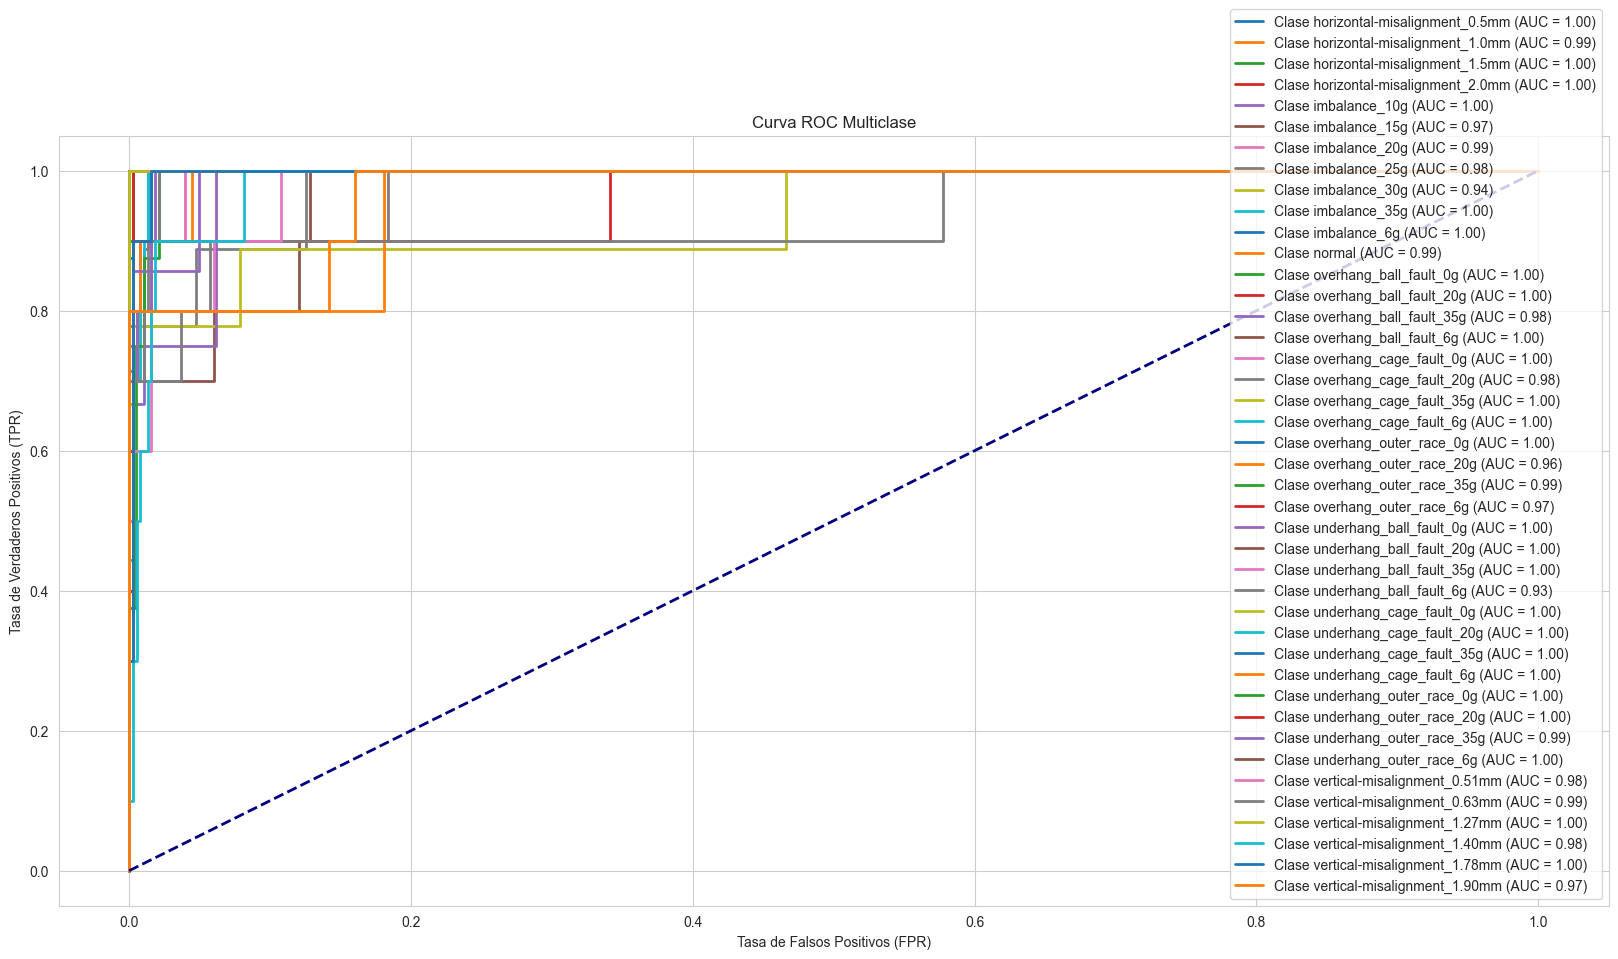

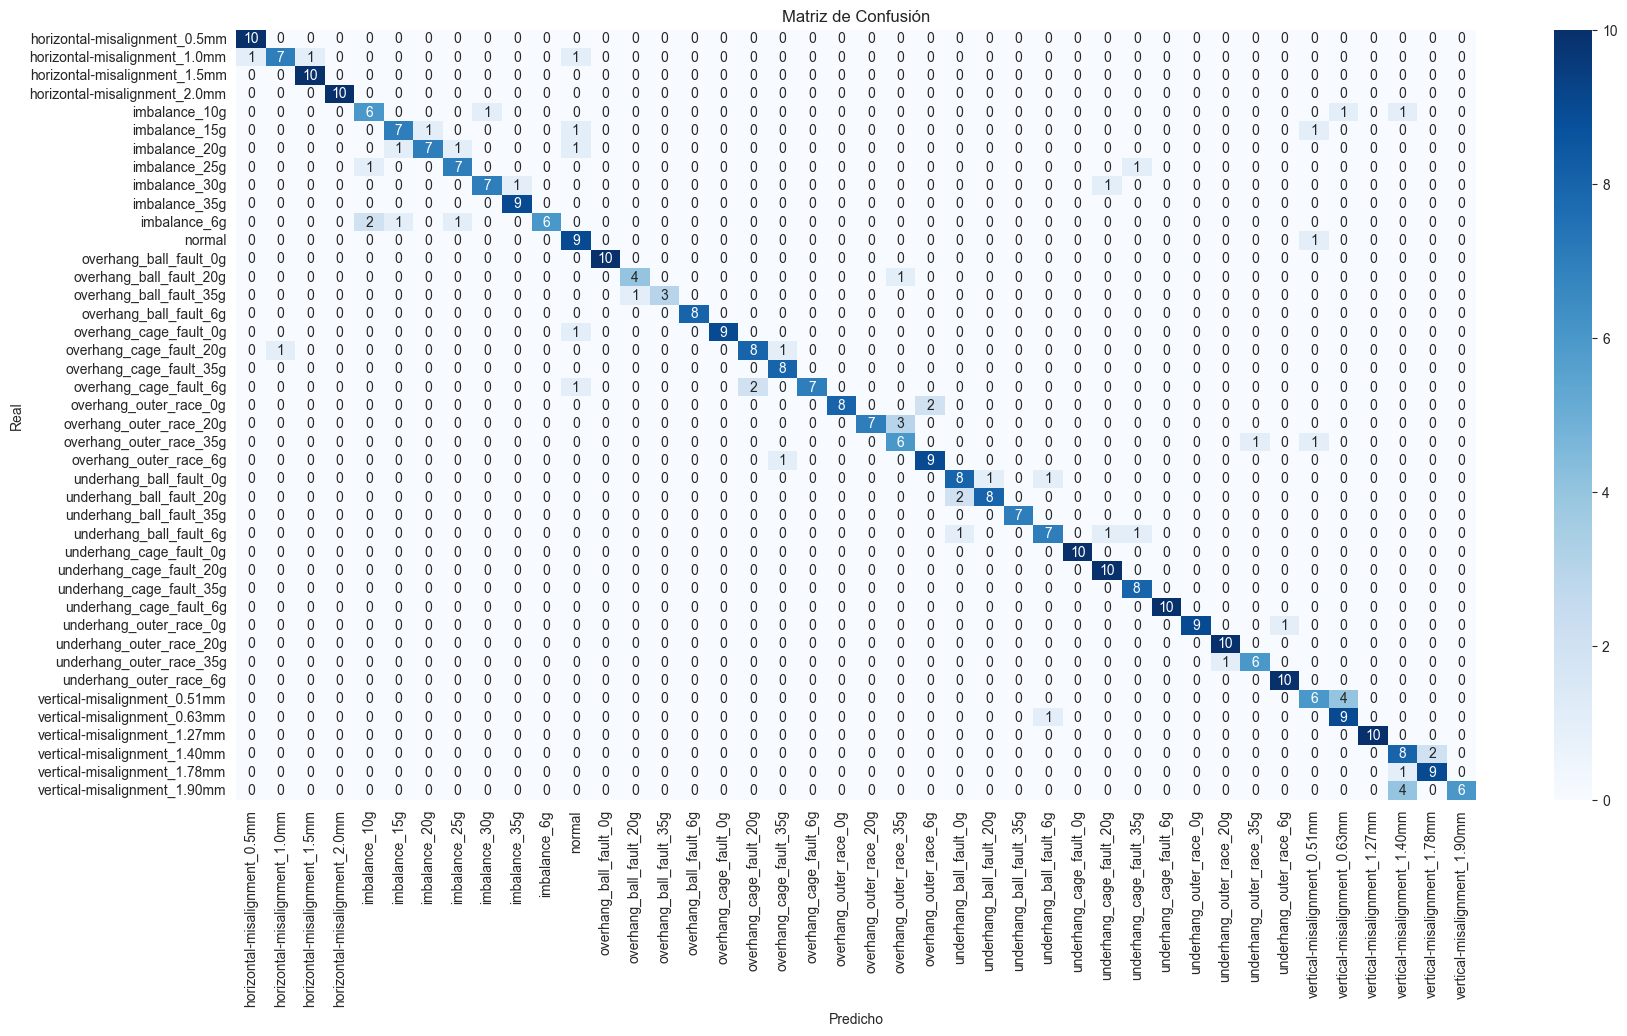

In [42]:
# Binarizar las etiquetas para manejo multiclase
classes = sorted(set(y_test))
y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = gb_classifier.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(20, 10))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()


cm = confusion_matrix(y_test_decoded, y_pred)
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title(f'Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

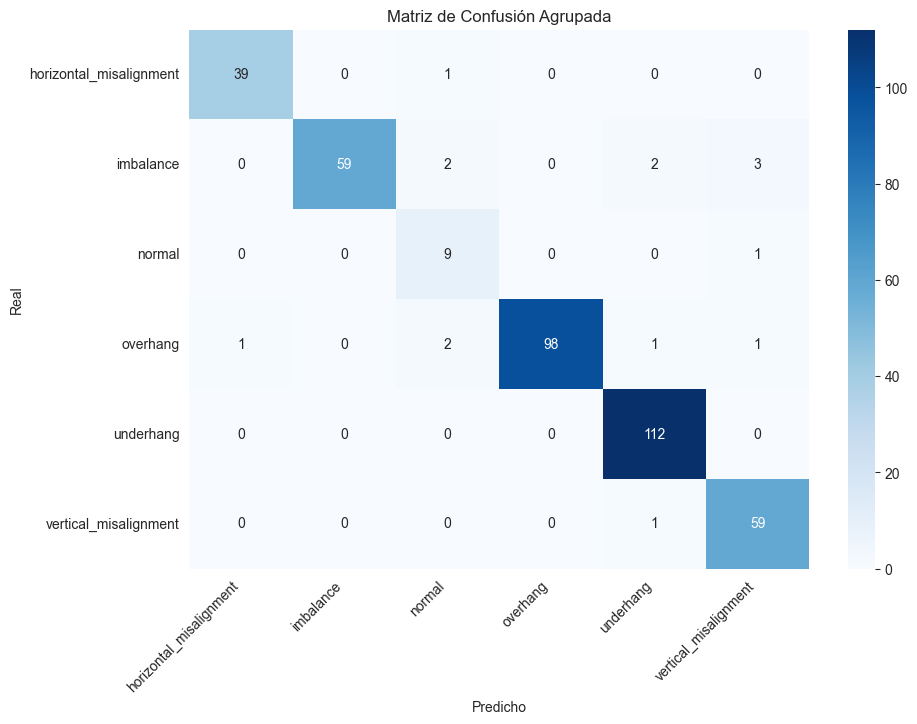

In [47]:
group_mapping = {
    'horizontal-misalignment_0.5mm': 'horizontal_misalignment',
    'horizontal-misalignment_1.0mm': 'horizontal_misalignment',
    'horizontal-misalignment_1.5mm': 'horizontal_misalignment',
    'horizontal-misalignment_2.0mm': 'horizontal_misalignment',
    'vertical-misalignment_0.51mm': 'vertical_misalignment',
    'vertical-misalignment_0.63mm': 'vertical_misalignment',
    'vertical-misalignment_1.27mm': 'vertical_misalignment',
    'vertical-misalignment_1.40mm': 'vertical_misalignment',
    'vertical-misalignment_1.78mm': 'vertical_misalignment',
    'vertical-misalignment_1.90mm': 'vertical_misalignment',
    'imbalance_6g': 'imbalance',
    'imbalance_10g': 'imbalance',
    'imbalance_20g': 'imbalance',
    'imbalance_15g': 'imbalance',
    'imbalance_25g': 'imbalance',
    'imbalance_30g': 'imbalance',
    'imbalance_35g': 'imbalance',
    'overhang_ball_fault_0g': 'overhang',
    'overhang_ball_fault_6g': 'overhang',
    'overhang_ball_fault_20g': 'overhang',
    'overhang_ball_fault_35g': 'overhang',
    'overhang_cage_fault_0g': 'overhang',
    'overhang_cage_fault_6g': 'overhang',
    'overhang_cage_fault_20g': 'overhang',
    'overhang_cage_fault_35g': 'overhang',
    'overhang_outer_race_0g': 'overhang',
    'overhang_outer_race_6g': 'overhang',
    'overhang_outer_race_20g': 'overhang',
    'overhang_outer_race_35g': 'overhang',
    'underhang_ball_fault_0g': 'underhang',
    'underhang_ball_fault_6g': 'underhang',
    'underhang_ball_fault_20g': 'underhang',
    'underhang_ball_fault_35g': 'underhang',
    'underhang_cage_fault_0g': 'underhang',
    'underhang_cage_fault_6g': 'underhang',
    'underhang_cage_fault_20g': 'underhang',
    'underhang_cage_fault_35g': 'underhang',
    'underhang_outer_race_0g': 'underhang',
    'underhang_outer_race_6g': 'underhang',
    'underhang_outer_race_20g': 'underhang',
    'underhang_outer_race_35g': 'underhang',
    'normal': 'normal'
}

# Reasignar etiquetas
y_test_grouped = [group_mapping[label] for label in y_test_decoded]
y_pred_grouped = [group_mapping[label] for label in y_pred]

# Calcular nueva matriz de confusión
grouped_classes = sorted(set(group_mapping.values()))
cm_grouped = confusion_matrix(y_test_grouped, y_pred_grouped, labels=grouped_classes)

# Dibujar matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_grouped, annot=True, fmt='d', cmap='Blues',
            xticklabels=grouped_classes,
            yticklabels=grouped_classes)
plt.title('Matriz de Confusión Agrupada')
plt.xlabel('Predicho')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Real')
plt.show()

#### Comparacion de los modelos

In [44]:
models = [rf_model,  gb_classifier, xgb_clf]
models_names = ['Random Forest','Gradient Boosting','XGBoost']

# Cálculo de puntuaciones para cada modelo
train_score = []
test_score = []

for model, name in zip(models, models_names):
    if name == 'XGBoost':
        y_encoded = label_encoder.fit_transform(y)
        X_train, X_test, y_train, y_test = train_test_split(X_reducida2, y_encoded, test_size=0.2, random_state=42, stratify=y)
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        train_score.append(accuracy_score(y_train, train_predictions))
        test_score.append(accuracy_score(y_test, test_predictions))
    else:
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))

# Diferencia entre las puntuaciones de entrenamiento y prueba
ratio = [f'{(train - test) * 100:.2f}%' for train, test in zip(train_score, test_score)]

model_score = pd.DataFrame({
    'Model': models_names,
    'Train score': [f'{round(score * 100, 2)}%' for score in train_score],
    'Test score': [f'{round(score * 100, 2)}%' for score in test_score],
    'Ratio difference': ratio
})

# Show result:
model_score

Model Train score Test score Ratio difference
0      Random Forest      100.0%     92.58%            7.42%
1  Gradient Boosting      100.0%     85.17%           14.83%
2            XGBoost      99.87%     84.91%           14.96%

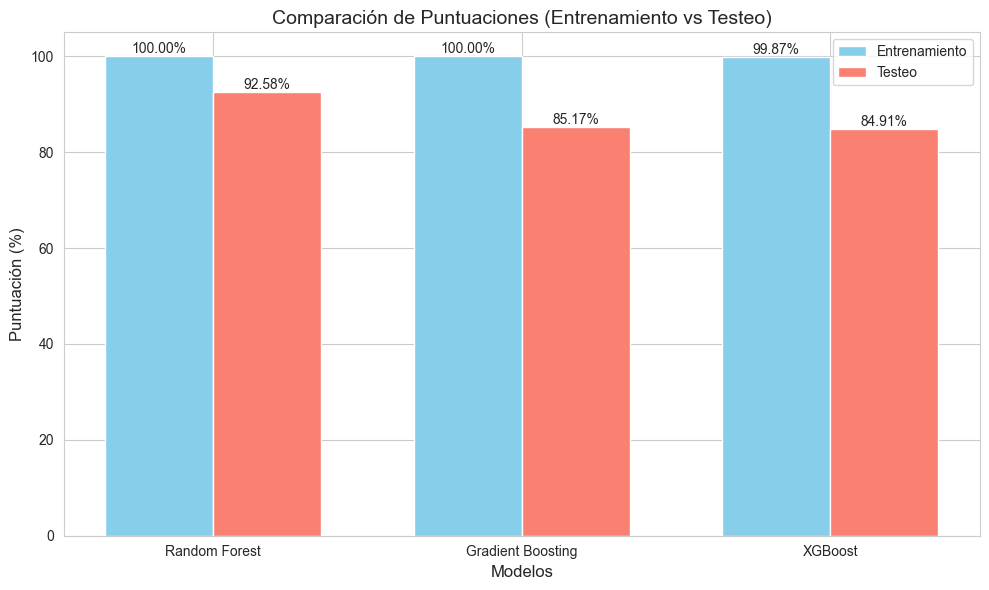

In [45]:
x = np.arange(len(models_names))  
train_scores = [score * 100 for score in train_score]
test_scores = [score * 100 for score in test_score]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35  

# Barras para training y testing
train_bars = ax.bar(x - width/2, train_scores, width, label='Entrenamiento', color='skyblue')
test_bars = ax.bar(x + width/2, test_scores, width, label='Testeo', color='salmon')

# Añadir etiquetas y título
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Puntuación (%)', fontsize=12)
ax.set_title('Comparación de Puntuaciones (Entrenamiento vs Testeo)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()

# Mostrar valores en las barras
for bar in train_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%', ha='center', va='bottom')

for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()